In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
!pip install gensim==4.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 76.2 MB/s eta 0:00:00
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20431 sha256=2ece40ae514153b0c4338c1cfd12660ed71adaf4dc7105c990bf3755286038b9
  Stored in directory: /root/.cache/pip/wheels/69/f5/e5/18ad53fe1ed6b2af9fad05ec052e4acbac8e92441df44bad2e
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3506 sha256=e371e6934d6a22aabfded5f5d1e3340aeae705286ec4b4f5006fce7517d5f364
  Stored in directory: /root/.cach

In [ ]:
# prompt: Can you generate the same code as below step by step for 'train_data_text.pkl' ;
# # --- 0. Load and Extract Paragraphs ---
# # Assuming the file 'X_train_documents_wrapped.txt' is in the same directory
# file_path = 'X_train_documents_wrapped.txt'
# document_list = []
# try:
#     with open(file_path, 'r', encoding='utf-8') as f:
#         content = f.read()
#     # Extract paragraphs enclosed in curly braces
#     paragraphs = re.findall(r'\{(.*?)\}', content, re.DOTALL)
#     # Store the paragraphs in a list, stripping whitespace and filtering empty ones
#     document_list = [p.strip() for p in paragraphs if p.strip()]
#     print(f"Successfully extracted {len(document_list)} non-empty paragraphs.")
# except FileNotFoundError:
#     print(f"Error: File not found at {file_path}")
#     exit() # Exit if file not found
# except Exception as e:
#     print(f"Error reading or parsing file: {e}")
#     exit() # Exit on other file processing errors

import pickle

# --- 0. Load and Extract Paragraphs ---
# Assuming the file 'train_data_text.pkl' is in the same directory
file_path = '/content/train_data_text .pkl'
document_list = []
try:
    with open(file_path, 'rb') as f:
        # Load the data from the pickle file
        data = pickle.load(f)
    # Assuming the pickle file directly contains the list of documents or a structure where the list is easily accessible
    # You might need to adjust this based on the actual structure of your pickle file
    # For example, if it's a dictionary, you might need data['documents']
    if isinstance(data, list):
        document_list = data
    else:
        # If the data is not directly a list, try to find the list of documents within it.
        # This is a placeholder; adjust based on the actual structure.
        # For example, if the data is a dictionary and the documents are under the key 'text':
        # document_list = data.get('text', [])
        print("Warning: Pickled data is not directly a list. Attempting to process based on assumptions.")
        # As a fallback, if the structure is complex, you might need specific code to extract.
        # If data is a dictionary with a key 'texts' containing the list:
        document_list = data.get('texts', []) # Example key, replace with actual
        if not document_list:
             print("Could not automatically find a list of documents in the pickled data.")
             # Handle cases where the list is not found or structure is unknown
             # For demonstration, assuming the pickle contains a simple list of strings
             # If your pickle file is structured differently, you'll need to modify this.
             # Let's assume for this example, if it's not a list, it might be a structure like {'documents': [...]}
             if isinstance(data, dict) and 'documents' in data:
                 document_list = data['documents']
             else:
                 print("Cannot extract document list from the given pickle structure.")
                 exit()


    # Filter out empty documents if any
    document_list = [doc.strip() for doc in document_list if doc and isinstance(doc, str) and doc.strip()]

    print(f"Successfully loaded and processed {len(document_list)} non-empty documents from pickle file.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit() # Exit if file not found
except Exception as e:
    print(f"Error reading or parsing pickle file: {e}")
    exit() # Exit on other file processing errors

Successfully loaded and processed 1500 non-empty documents from pickle file.


In [ ]:
# Print the first few documents to preview the data
print("\nPreview of the first 5 documents:")
for i, doc in enumerate(document_list[:5]):
    print(f"--- Document {i+1} ---")
    print(doc)
    print("-" * (len(f"--- Document {i+1} ---")))

# Optionally, print some basic statistics about the documents
print(f"\nTotal number of documents loaded: {len(document_list)}")
if document_list:
    doc_lengths = [len(doc.split()) for doc in document_list]
    print(f"Average document length (words): {np.mean(doc_lengths):.2f}")
    print(f"Median document length (words): {np.median(doc_lengths)}")
    print(f"Maximum document length (words): {np.max(doc_lengths)}")
    print(f"Minimum document length (words): {np.min(doc_lengths)}")
else:
    print("No documents were loaded.")


Preview of the first 5 documents:
--- Document 1 ---
In article <93089.204431GRV101@psuvm.psu.edu> Callec Dradja <GRV101@psuvm.psu.edu> writes:
>I am a bit nervous about posting this beacause it is begining to
>stray fron the topic of space but then again that doesn't seem to
>stop alot of other people. :-)
>
>With all of this talk about breathing at high pressures, I began
>to think about the movie Abyss. If you remember, in that movie one
>of the characters dove to great depths by wearing a suit that used
>a fluid that carries oxegen as opposed to some sort of gas. Now I
>have heard that mice can breath this fluid but for some reason, humans
>are unable to. Does anyone know more details about this?
>
>Gregson Vaux
>

I believe the reason is that the lung diaphram gets too tired to pump
the liquid in and out and simply stops breathing after 2-3 minutes.
So if your in the vehicle ready to go they better not put you on 
hold, or else!! That's about it. Remember a liquid is several more

In [ ]:
from sklearn.model_selection import train_test_split

# Ensure document_list is not empty before splitting
if document_list:
    # Split the document_list into training and testing sets
    # train_size=0.8 means 80% for training, test_size=0.2 means 20% for testing
    # random_state is set for reproducibility
    document_list_train, document_list_test = train_test_split(
        document_list, train_size=0.8, test_size=0.2, random_state=42
    )

    print(f"Original document list size: {len(document_list)}")
    print(f"Training partition size (80%): {len(document_list_train)}")
    print(f"Testing partition size (20%): {len(document_list_test)}")
else:
    print("document_list is empty. Cannot perform partitioning.")

Original document list size: 1500
Training partition size (80%): 1200
Testing partition size (20%): 300


In [ ]:
# --- 1. Text Preprocessing Steps ---

# Download necessary NLTK data (run this once in your environment)
# The download function will check if the data is already present
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

import re
import string

def preprocess_text(text):
    """Applies a series of preprocessing steps to a text string."""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words and short words (length > 1)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return tokens

# Apply preprocessing to the extracted paragraphs
# Each element in preprocessed_documents is a list of tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download('punkt_tab')

preprocessed_documents = [preprocess_text(doc) for doc in document_list_train]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
print("\n--- Text Preprocessing Complete ---")
print(f"First original document: {document_list_train[0][:200]}...")
print(f"First preprocessed document (tokens): {preprocessed_documents[0][:30]}...")


--- Text Preprocessing Complete ---
First original document: try finding a friend that has caller id, then give him a call...

jb


In article <20756.2bd16dea@ecs.umass.edu> alee@ecs.umass.edu writes:

   Path: shearson.com!uupsi!psinntp!uunet!haven.umd.edu!dar...
First preprocessed document (tokens): ['try', 'finding', 'friend', 'caller', 'id', 'give', 'call', 'jb', 'article', 'bddeaecsumassedu', 'aleeecsumassedu', 'writes', 'path', 'shearsoncomuupsipsinntpuunethavenumdedudarwinsuranetnewsserverjvncnethowlandrestonansnetnocnearnetnicumasseduriskyecsumasseduumaecsalee', 'aleeecsumassedu', 'newsgroups', 'scielectronics', 'date', 'apr', 'gmt', 'lines', 'greetings', 'situation', 'phone', 'jack', 'mounted', 'wall', 'dont', 'know', 'number']...



--- Basic EDA: Paragraph Length Analysis ---
Average paragraph length: 144.43 tokens
Median paragraph length: 86.0 tokens
Min paragraph length: 1 tokens
Max paragraph length: 3742 tokens


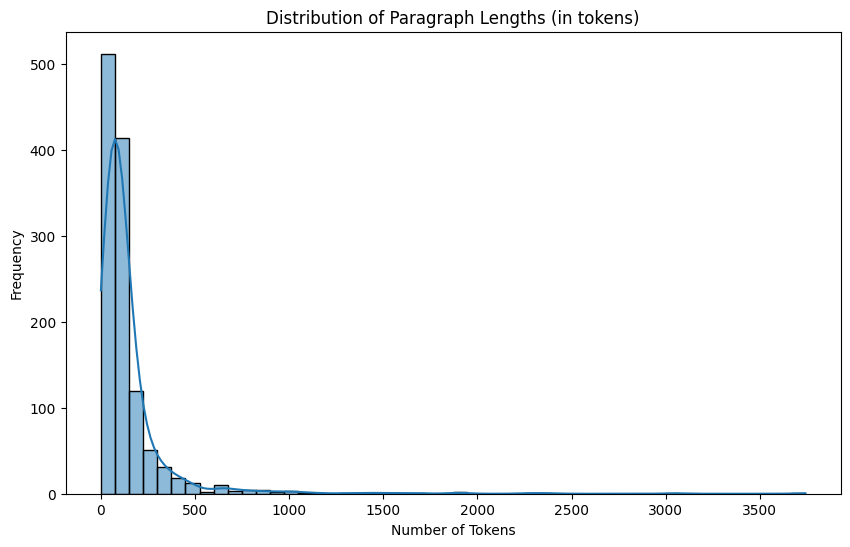

In [ ]:
import numpy as np
# --- 2. Basic EDA Steps ---

# Paragraph Length Analysis (in terms of number of tokens)
paragraph_lengths = [len(doc) for doc in preprocessed_documents]

print("\n--- Basic EDA: Paragraph Length Analysis ---")
print(f"Average paragraph length: {np.mean(paragraph_lengths):.2f} tokens")
print(f"Median paragraph length: {np.median(paragraph_lengths)} tokens")
print(f"Min paragraph length: {np.min(paragraph_lengths)} tokens")
print(f"Max paragraph length: {np.max(paragraph_lengths)} tokens")

# Plotting the distribution of paragraph lengths
plt.figure(figsize=(10, 6))
sns.histplot(paragraph_lengths, bins=50, kde=True)
plt.title('Distribution of Paragraph Lengths (in tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Word Frequency Analysis (Top N words) - requires flattening the list of lists
all_words = [word for tokens in preprocessed_documents for word in tokens]
# Corrected typo in the class name from FrequencuDist to FreqDist
fdist = nltk.FreqDist(all_words)
most_common_words = fdist.most_common(50)

print("\n--- Basic EDA: Top 50 Most Common Words ---")
for word, frequency in most_common_words:
    print(f"{word}: {frequency}")


--- Basic EDA: Top 50 Most Common Words ---
would: 1057
writes: 1028
one: 1013
article: 901
people: 784
dont: 676
like: 670
think: 569
know: 547
get: 527
us: 463
also: 437
im: 430
time: 414
well: 414
even: 412
see: 397
could: 386
make: 386
new: 383
way: 372
space: 370
good: 364
may: 359
want: 336
much: 336
use: 333
going: 328
work: 325
go: 323
nntppostinghost: 323
say: 318
many: 316
right: 315
said: 311
first: 307
god: 297
government: 296
something: 275
two: 274
jesus: 266
world: 264
really: 263
still: 255
dod: 250
used: 248
point: 246
take: 244
anyone: 240
believe: 236


In [ ]:
# PCA will be performed after Word2Vec vectorization.

# --- 3. Vectorization using Word2Vec ---

# Train the Word2Vec model
# Using skip-gram (sg=1), window size 5, min_count 5 (ignore words with freq < 5),
# vector size 100, and train on multiple cores if available.
# The problem statement mentions 5 true classes, a vector size like 100 is a common starting point.
print("\n--- Training Word2Vec Model ---")
word2vec_model = Word2Vec(sentences=preprocessed_documents,
                          vector_size=100,
                          window=5,
                          min_count=5,
                          workers=4, # Adjust based on your system's cores
                          sg=1) # 1 for skip-gram, 0 for CBOW

print("Word2Vec model training complete.")
print(f"Vocabulary size: {len(word2vec_model.wv)}")


--- Training Word2Vec Model ---
Word2Vec model training complete.
Vocabulary size: 5954


In [ ]:
# Create paragraph embeddings by averaging word vectors
def document_vector(word2vec_model, doc):
    """Averages the word vectors for a document, handling words not in vocabulary."""
    # Filter out words not in the model's vocabulary
    words = [word for word in doc if word in word2vec_model.wv]
    if not words:
        return np.zeros(word2vec_model.wv.vector_size)
    # Average the word vectors
    return np.mean(word2vec_model.wv[words], axis=0)

In [ ]:
# Create vectors for each document
document_vectors = np.array([document_vector(word2vec_model, doc) for doc in preprocessed_documents])

print("\n--- Document Vectorization Complete ---")
print(f"Shape of document vectors: {document_vectors.shape}")


--- Document Vectorization Complete ---
Shape of document vectors: (1200, 100)



--- PCA on Word2Vec Embeddings Complete ---
Shape of PCA-reduced document vectors: (1200, 5)


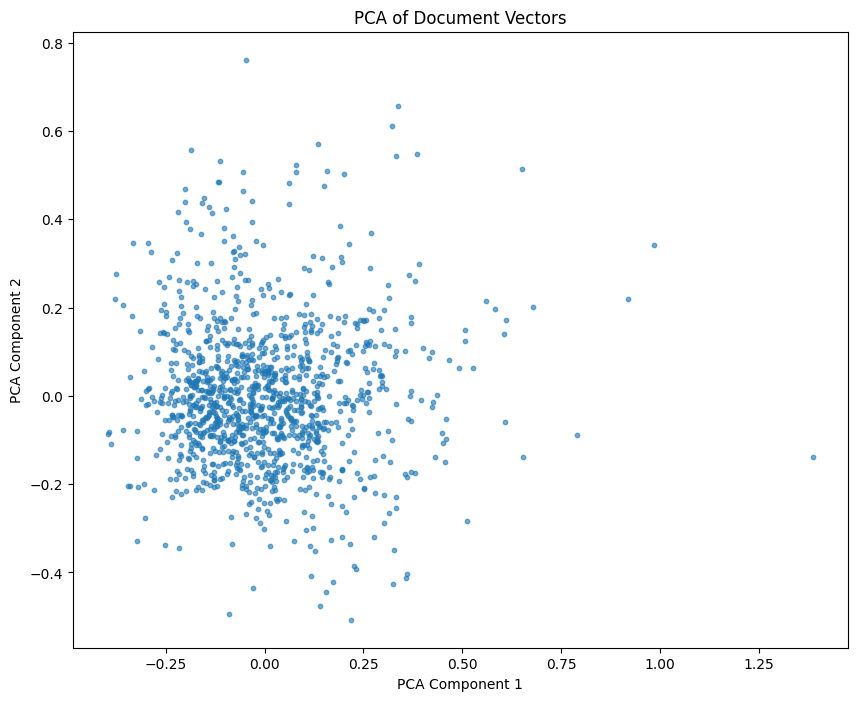

In [ ]:
# --- 2b. Basic EDA: PCA on Word2Vec Embeddings ---

# Perform PCA for dimensionality reduction for potential visualization and EDA
# Reducing to 2 components for visualization
pca = PCA(n_components=5)
document_vectors_pca = pca.fit_transform(document_vectors)

print("\n--- PCA on Word2Vec Embeddings Complete ---")
print(f"Shape of PCA-reduced document vectors: {document_vectors_pca.shape}")

# Visualize the PCA-reduced data (optional, but helpful for EDA)
plt.figure(figsize=(10, 8))
plt.scatter(document_vectors_pca[:, 0], document_vectors_pca[:, 1], s=10, alpha=0.6)
plt.title('PCA of Document Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

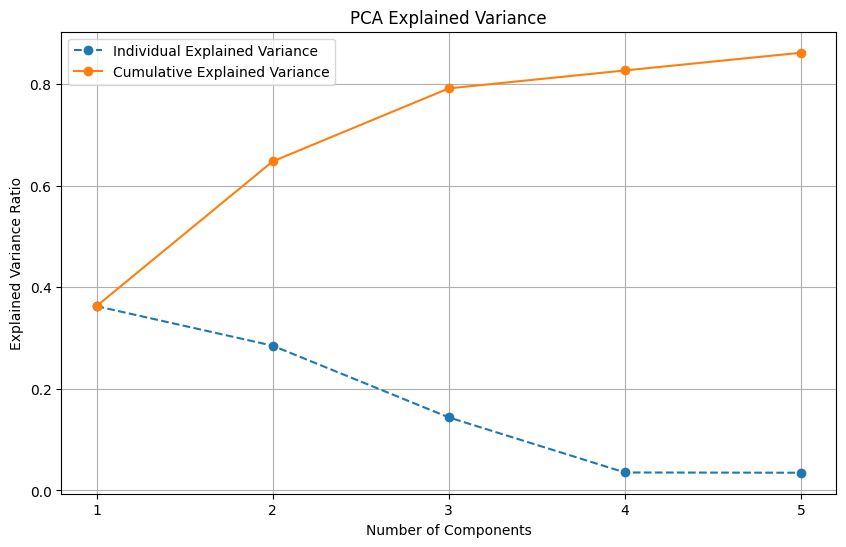


--- PCA Explained Variance Analysis ---
Explained variance by each component: [0.36292454 0.28508139 0.14384454 0.03534888 0.03487758]
Cumulative explained variance: [0.36292454 0.64800593 0.79185047 0.82719935 0.86207693]


In [ ]:
# prompt: plot PCA explained variance

# Explained Variance Plot
# Calculate the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label='Individual Explained Variance')
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', label='Cumulative Explained Variance')

plt.title('PCA Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.legend()
plt.show()

print("\n--- PCA Explained Variance Analysis ---")
print(f"Explained variance by each component: {explained_variance}")
print(f"Cumulative explained variance: {cumulative_explained_variance}")
# Note: This plot helps in deciding how many components to keep for further analysis or clustering.
# For clustering, you might want to keep enough components to explain a significant portion of the variance (e.g., 80-95%).


--- Generating t-SNE on PCA Components ---


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE dimensionality reduction complete.
Shape of t-SNE-reduced document vectors: (1200, 2)


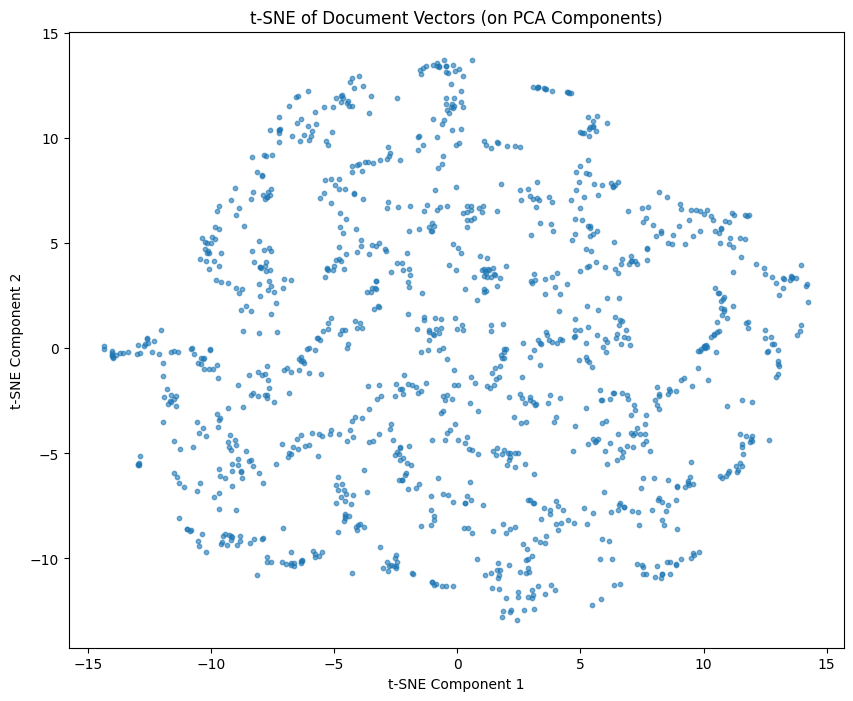

In [ ]:
# prompt: Also generate tsne on PCA components

!pip install scikit-learn matplotlib seaborn
from sklearn.manifold import TSNE

# Generate TSNE on the PCA components
print("\n--- Generating t-SNE on PCA Components ---")
# Common practice is to run t-SNE on a reduced set of components (e.g., from PCA)
# Adjust perplexity and n_iter based on your dataset size and desired outcome
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300) # Adjust perplexity and n_iter as needed
document_vectors_tsne = tsne.fit_transform(document_vectors_pca) # Apply t-SNE on PCA components

print("t-SNE dimensionality reduction complete.")
print(f"Shape of t-SNE-reduced document vectors: {document_vectors_tsne.shape}")

# Visualize the t-SNE reduced data
plt.figure(figsize=(10, 8))
plt.scatter(document_vectors_tsne[:, 0], document_vectors_tsne[:, 1], s=10, alpha=0.6)
plt.title('t-SNE of Document Vectors (on PCA Components)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


--- Exploring KMeans Clustering for different numbers of clusters ---
Clusters: 2, Silhouette Score: 0.2721, Davies-Bouldin Score: 1.4693, Calinski-Harabasz Score: 409.0967
Clusters: 3, Silhouette Score: 0.2616, Davies-Bouldin Score: 1.2728, Calinski-Harabasz Score: 391.9769
Clusters: 4, Silhouette Score: 0.2477, Davies-Bouldin Score: 1.2245, Calinski-Harabasz Score: 383.5514
Clusters: 5, Silhouette Score: 0.2275, Davies-Bouldin Score: 1.2402, Calinski-Harabasz Score: 371.0416
Clusters: 6, Silhouette Score: 0.2050, Davies-Bouldin Score: 1.2749, Calinski-Harabasz Score: 347.3047
Clusters: 7, Silhouette Score: 0.2031, Davies-Bouldin Score: 1.2667, Calinski-Harabasz Score: 326.4351
Clusters: 8, Silhouette Score: 0.2068, Davies-Bouldin Score: 1.2342, Calinski-Harabasz Score: 319.0763
Clusters: 9, Silhouette Score: 0.1945, Davies-Bouldin Score: 1.2555, Calinski-Harabasz Score: 304.3232
Clusters: 10, Silhouette Score: 0.1983, Davies-Bouldin Score: 1.2390, Calinski-Harabasz Score: 294.2003


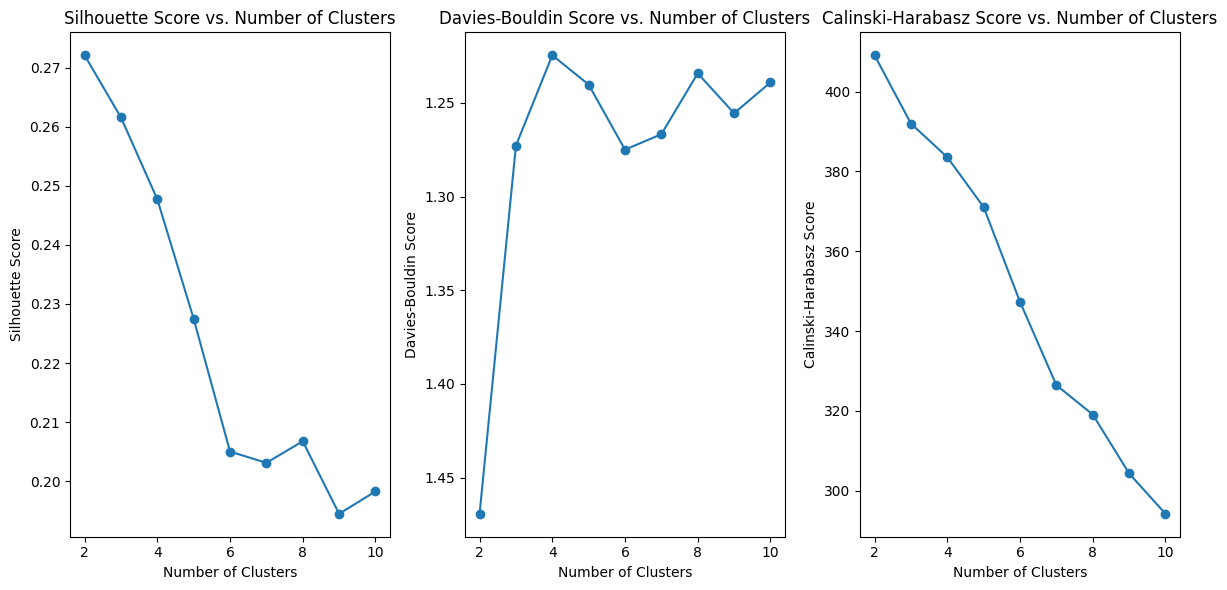

In [ ]:
# --- 4. Create the best model possible for clustering the data ---

# Determine the optimal number of clusters (e.g., using the Elbow Method or Silhouette Score)
# As a starting point, we will consider the 5 true classes mentioned in the problem statement
# Let's explore clustering for a range of clusters and evaluate using silhouette score

print("\n--- Exploring KMeans Clustering for different numbers of clusters ---")

# Range of clusters to evaluate (start around the expected number of classes)
k_range = range(2, 11) # Example range: from 2 up to 10 clusters
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for n_clusters in k_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # n_init='auto' in newer sklearn
    cluster_labels = kmeans.fit_predict(document_vectors_pca)

    # Evaluate clustering
    silhouette_avg = silhouette_score(document_vectors_pca, cluster_labels)
    davies_bouldin_avg = davies_bouldin_score(document_vectors_pca, cluster_labels)
    calinski_harabasz_avg = calinski_harabasz_score(document_vectors_pca, cluster_labels)

    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin_avg)
    calinski_harabasz_scores.append(calinski_harabasz_avg)

    print(f"Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}, Davies-Bouldin Score: {davies_bouldin_avg:.4f}, Calinski-Harabasz Score: {calinski_harabasz_avg:.4f}")

# Plotting evaluation scores vs. number of clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 2)
plt.plot(k_range, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.gca().invert_yaxis() # Lower Davies-Bouldin is better

plt.subplot(1, 3, 3)
plt.plot(k_range, calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.show()

In [ ]:
# Re-run KMeans specifically for 5 clusters to get the exact score
n_clusters_to_check = 5
kmeans_5 = KMeans(n_clusters=n_clusters_to_check, random_state=42, n_init=10)
cluster_labels_5 = kmeans_5.fit_predict(document_vectors_pca)

silhouette_avg_5 = silhouette_score(document_vectors_pca, cluster_labels_5)
davies_bouldin_avg_5 = davies_bouldin_score(document_vectors_pca, cluster_labels_5)
calinski_harabasz_avg_5 = calinski_harabasz_score(document_vectors_pca, cluster_labels_5)

print(f"\n--- Evaluation for {n_clusters_to_check} Clusters ---")
print(f"Silhouette Score for {n_clusters_to_check} clusters: {silhouette_avg_5:.4f}")
print(f"Davies-Bouldin Score for {n_clusters_to_check} clusters: {davies_bouldin_avg_5:.4f}")
print(f"Calinski-Harabasz Score for {n_clusters_to_check} clusters: {calinski_harabasz_avg_5:.4f}")

# Find the index of the best silhouette score
best_silhouette_index = np.argmax(silhouette_scores)
best_n_clusters_silhouette = list(k_range)[best_silhouette_index]
highest_silhouette_score = silhouette_scores[best_silhouette_index]

print(f"\nHighest Silhouette Score ({highest_silhouette_score:.4f}) was achieved with {best_n_clusters_silhouette} clusters.")

if best_n_clusters_silhouette == n_clusters_to_check:
    print(f"\nChoosing {n_clusters_to_check} clusters resulted in the highest silhouette score among the tested range.")
elif silhouette_avg_5 > np.mean(silhouette_scores): # Example comparison
    print(f"\nChoosing {n_clusters_to_check} clusters resulted in a better than average silhouette score ({silhouette_avg_5:.4f}) among the tested range, but not the highest.")
else:
     print(f"\nChoosing {n_clusters_to_check} clusters resulted in a silhouette score ({silhouette_avg_5:.4f}) that is not the highest among the tested range. The highest is {highest_silhouette_score:.4f} with {best_n_clusters_silhouette} clusters.")




--- Evaluation for 5 Clusters ---
Silhouette Score for 5 clusters: 0.2275
Davies-Bouldin Score for 5 clusters: 1.2402
Calinski-Harabasz Score for 5 clusters: 371.0416

Highest Silhouette Score (0.2721) was achieved with 2 clusters.

Choosing 5 clusters resulted in a better than average silhouette score (0.2275) among the tested range, but not the highest.



--- KMeans Clustering performed with 5 clusters ---

First 5 documents with their assigned clusters:
                                   Original Document  Cluster
0  try finding a friend that has caller id, then ...        3
1  In article <sandvik-150493181533@sandvik-kent....        2
2  In article <1993Mar25.161909.8110@wuecl.wustl....        1
3  Hi All!\n\n   I would like to know what are th...        3
4  In article <1qn4bgINN4s7@mimi.UU.NET> goltz@mi...        3

Document count per cluster:
0    121
1    406
2    123
3    348
4    202
Name: Cluster, dtype: int64

Example documents from each cluster:

--- Cluster 0 ---
  Doc 1: Reply-To: an030@cleveland.Freenet.Edu (Broward Horne)
NNTP-Posting-Host: hela.ins.cwru.edu


In a previous article, spl@pitstop.ucsd.edu (Steve Lamont) says:

>... or consider the thousands in Central...
  Doc 2: NNTP-Posting-Host: lloyd.caltech.edu

kevin@rotag.mi.org (Kevin Darcy) writes:

>In article <1993Apr15.010329.23133@mnemosyne.cs.du.edu> kcochran

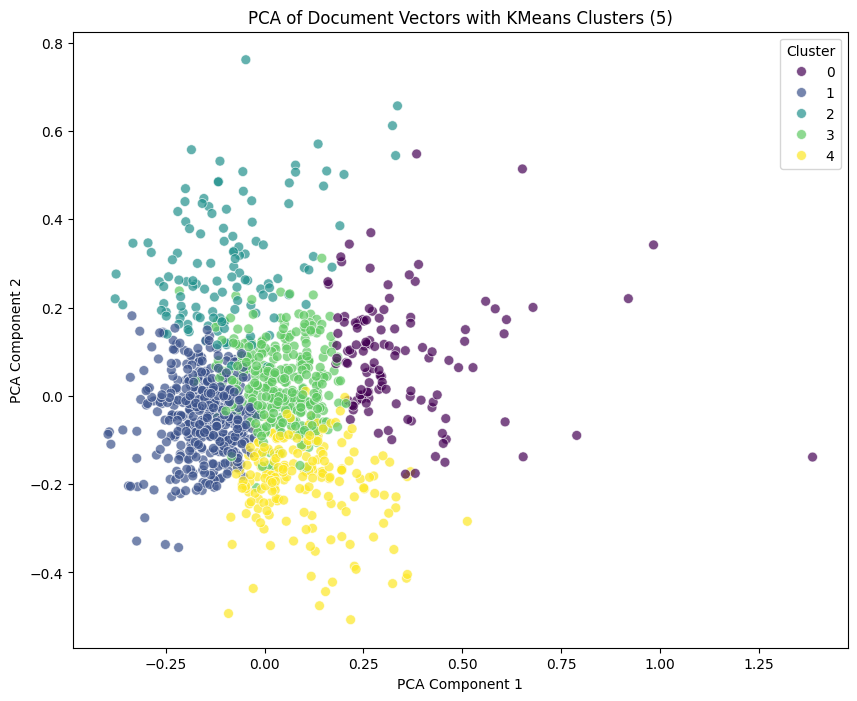

In [ ]:
# Perform KMeans clustering with 5 clusters, as specified
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(document_vectors_pca)

print(f"\n--- KMeans Clustering performed with {n_clusters} clusters ---")

# Add cluster labels to the original document list or a DataFrame for analysis
# Create a Pandas DataFrame to easily inspect documents and their assigned clusters
# CORRECTED: Use document_list_train instead of document_list
df_clustered = pd.DataFrame({
    'Original Document': document_list_train,
    'Preprocessed Tokens': preprocessed_documents,
    'Cluster': cluster_labels
})

print("\nFirst 5 documents with their assigned clusters:")
print(df_clustered[['Original Document', 'Cluster']].head())

# You can further analyze the clusters, e.g., look at centroids, or explore the documents in each cluster.
# Example: Count documents per cluster
print("\nDocument count per cluster:")
print(df_clustered['Cluster'].value_counts().sort_index())

# Example: Display a few documents from each cluster
print("\nExample documents from each cluster:")
for cluster_id in sorted(df_clustered['Cluster'].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    cluster_docs = df_clustered[df_clustered['Cluster'] == cluster_id]['Original Document']
    for i, doc in enumerate(cluster_docs.sample(min(3, len(cluster_docs)), random_state=42)): # Sample up to 3 docs
        print(f"  Doc {i+1}: {doc[:200]}...") # Print first 200 characters

# You can optionally visualize the PCA-reduced data colored by cluster
if 'document_vectors_pca' in locals():
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=document_vectors_pca[:, 0], y=document_vectors_pca[:, 1], hue=cluster_labels, palette='viridis', s=50, alpha=0.7)
    plt.title(f'PCA of Document Vectors with KMeans Clusters ({n_clusters})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

In [ ]:
# Since true labels are not provided, we cannot calculate external accuracy metrics
# like Adjusted Rand Index or Normalized Mutual Information directly.
# However, we can report the internal evaluation metrics calculated earlier,
# which indicate the quality of the clustering based on the data itself.

print("\n--- Internal Clustering Evaluation Metrics for the Final 5-Cluster Model ---")

# Recalculate metrics for the final 5-cluster model for clarity
n_clusters_final = 5
kmeans_final = KMeans(n_clusters=n_clusters_final, random_state=42, n_init=10)
cluster_labels_final = kmeans_final.fit_predict(document_vectors_pca)

silhouette_avg_final = silhouette_score(document_vectors_pca, cluster_labels_final)
davies_bouldin_avg_final = davies_bouldin_score(document_vectors_pca, cluster_labels_final)
calinski_harabasz_avg_final = calinski_harabasz_score(document_vectors_pca, cluster_labels_final)

print(f"Silhouette Score: {silhouette_avg_final:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_avg_final:.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_avg_final:.4f}")

print("\nNote: These are internal evaluation metrics, not a measure of accuracy against true labels.")
print("A higher Silhouette Score and Calinski-Harabasz Score, and a lower Davies-Bouldin Score generally indicate better-defined clusters.")
print("The values calculated for different numbers of clusters above help in selecting the best 'k'.")


--- Internal Clustering Evaluation Metrics for the Final 5-Cluster Model ---
Silhouette Score: 0.2275
Davies-Bouldin Score: 1.2402
Calinski-Harabasz Score: 371.0416

Note: These are internal evaluation metrics, not a measure of accuracy against true labels.
A higher Silhouette Score and Calinski-Harabasz Score, and a lower Davies-Bouldin Score generally indicate better-defined clusters.
The values calculated for different numbers of clusters above help in selecting the best 'k'.



--- Exploring KMeans Clustering with TF-IDF vectors ---
TF-IDF Vectorization complete.
Shape of TF-IDF vectors: (1200, 11533)
TF-IDF - Clusters: 2, Silhouette Score: 0.0035, Davies-Bouldin Score: 15.3620, Calinski-Harabasz Score: 4.9758
TF-IDF - Clusters: 3, Silhouette Score: 0.0039, Davies-Bouldin Score: 10.4553, Calinski-Harabasz Score: 5.2838
TF-IDF - Clusters: 4, Silhouette Score: 0.0040, Davies-Bouldin Score: 11.8721, Calinski-Harabasz Score: 4.5904
TF-IDF - Clusters: 5, Silhouette Score: 0.0044, Davies-Bouldin Score: 11.6160, Calinski-Harabasz Score: 4.2764
TF-IDF - Clusters: 6, Silhouette Score: 0.0055, Davies-Bouldin Score: 9.9331, Calinski-Harabasz Score: 4.3668
TF-IDF - Clusters: 7, Silhouette Score: 0.0056, Davies-Bouldin Score: 11.0916, Calinski-Harabasz Score: 3.7167
TF-IDF - Clusters: 8, Silhouette Score: 0.0060, Davies-Bouldin Score: 10.2963, Calinski-Harabasz Score: 3.6163
TF-IDF - Clusters: 9, Silhouette Score: 0.0053, Davies-Bouldin Score: 9.3974, Calinski-Harabasz S

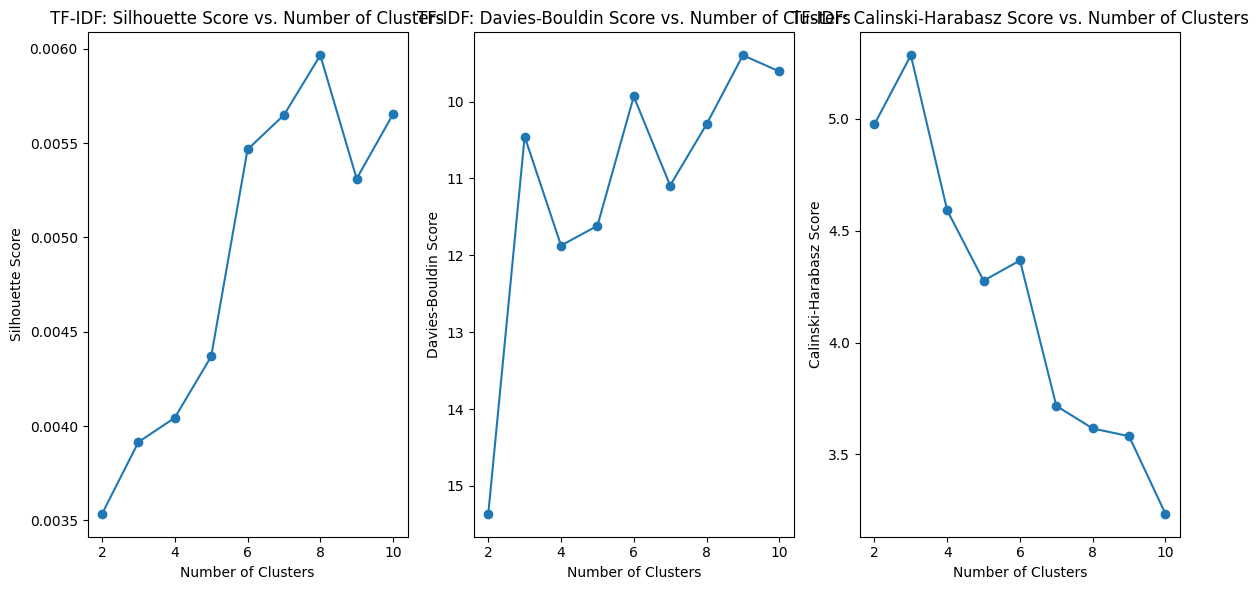

In [ ]:
# --- 4a. Exploring Clustering with TF-IDF vectors ---

print("\n--- Exploring KMeans Clustering with TF-IDF vectors ---")

# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Add TF-IDF Vectorization Step ---
# Create string representations of the preprocessed documents for TF-IDF
# TF-IDF vectorizer expects a list of strings, where each string is a document.
# Join the tokens back into a string for each document.
preprocessed_documents_str = [" ".join(doc) for doc in preprocessed_documents]

# Initialize the TfidfVectorizer
# You can adjust parameters like max_df, min_df, ngram_range as needed
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit the vectorizer on the training data and transform it
tfidf_vectors = tfidf_vectorizer.fit_transform(preprocessed_documents_str)

print("TF-IDF Vectorization complete.")
print(f"Shape of TF-IDF vectors: {tfidf_vectors.shape}")
# --- End of Added TF-IDF Vectorization Step ---


k_range_tfidf = range(2, 11)
silhouette_scores_tfidf = []
davies_bouldin_scores_tfidf = []
calinski_harabasz_scores_tfidf = []

# Note: KMeans can be sensitive to the scale of features. TF-IDF is somewhat normalized,
# but StandardScaler could be applied if needed, though it would make sparse matrices dense.

# Convert sparse TF-IDF vectors to dense for evaluation metrics
# Use np.asarray to convert the numpy.matrix to a numpy.ndarray
# tfidf_vectors is now defined from the step above.
tfidf_vectors_dense = np.asarray(tfidf_vectors.todense())


for n_clusters in k_range_tfidf:
    # Removed n_init='auto' as it might not be compatible with older sklearn versions used
    # in the environment. Use n_init=10 as in previous cells.
    kmeans_tfidf = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    # KMeans supports sparse input (tfidf_vectors)
    cluster_labels_tfidf = kmeans_tfidf.fit_predict(tfidf_vectors)

    # Evaluate clustering on dense TF-IDF matrix (now a numpy array)
    silhouette_avg_tfidf = silhouette_score(tfidf_vectors_dense, cluster_labels_tfidf)
    davies_bouldin_avg_tfidf = davies_bouldin_score(tfidf_vectors_dense, cluster_labels_tfidf)
    calinski_harabasz_avg_tfidf = calinski_harabasz_score(tfidf_vectors_dense, cluster_labels_tfidf)


    silhouette_scores_tfidf.append(silhouette_avg_tfidf)
    davies_bouldin_scores_tfidf.append(davies_bouldin_avg_tfidf)
    calinski_harabasz_scores_tfidf.append(calinski_harabasz_avg_tfidf)

    print(f"TF-IDF - Clusters: {n_clusters}, Silhouette Score: {silhouette_avg_tfidf:.4f}, Davies-Bouldin Score: {davies_bouldin_avg_tfidf:.4f}, Calinski-Harabasz Score: {calinski_harabasz_avg_tfidf:.4f}")

# Plotting evaluation scores vs. number of clusters for TF-IDF
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(k_range_tfidf, silhouette_scores_tfidf, marker='o')
plt.title('TF-IDF: Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 2)
plt.plot(k_range_tfidf, davies_bouldin_scores_tfidf, marker='o')
plt.title('TF-IDF: Davies-Bouldin Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.gca().invert_yaxis() # Lower Davies-Bouldin is better

plt.subplot(1, 3, 3)
plt.plot(k_range_tfidf, calinski_harabasz_scores_tfidf, marker='o')
plt.title('TF-IDF: Calinski-Harabasz Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.show()

In [ ]:
# --- 4b. Exploring Agglomerative Clustering ---

print("\n--- Exploring Agglomerative Clustering with Word2Vec vectors ---")

from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering typically takes a distance metric.
# Using Word2Vec vectors (dense) is suitable.
# We will evaluate for k=5 (as specified in the problem context) but other ks can be explored.

n_clusters_agg = 5
# Note: In newer sklearn versions, 'metric' is preferred over 'affinity'.
# Use metric='euclidean' instead of affinity='euclidean'.
# For linkage='ward', the metric must be 'euclidean'.
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters_agg, metric='euclidean', linkage='ward') # 'ward' linkage is common
agg_cluster_labels = agg_clustering.fit_predict(document_vectors_pca)

print(f"Agglomerative Clustering performed with {n_clusters_agg} clusters on Word2Vec vectors.")

# Evaluate the Agglomerative Clustering result
silhouette_avg_agg = silhouette_score(document_vectors_pca, agg_cluster_labels)
davies_bouldin_avg_agg = davies_bouldin_score(document_vectors_pca, agg_cluster_labels)
calinski_harabasz_avg_agg = calinski_harabasz_score(document_vectors_pca, agg_cluster_labels)

print("\n--- Internal Clustering Evaluation Metrics for Agglomerative Clustering (5 Clusters) ---")
print(f"Silhouette Score: {silhouette_avg_agg:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_avg_agg:.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_avg_agg:.4f}")


# You can also plot the dendrogram to help choose the number of clusters for Agglomerative Clustering
# Note: Plotting a dendrogram for a large number of samples can be computationally expensive and the plot might be too dense.
# Let's skip it for now unless specifically requested or needed for visual inspection of hierarchy.

# Example of adding Agglomerative Cluster labels to the DataFrame
df_clustered['Agglomerative_Cluster_Word2Vec'] = agg_cluster_labels
print("\nDocument count per Agglomerative Cluster (Word2Vec):")
print(df_clustered['Agglomerative_Cluster_Word2Vec'].value_counts().sort_index())

# --- Further Improvements (Ideas to implement based on results) ---

# - Based on the evaluation metrics plots for both KMeans on Word2Vec and KMeans on TF-IDF,
#   select the 'k' and vectorization method that seems to yield the best internal scores.
#   The plots help identify potential optimal 'k' values where Silhouette is high and Davies-Bouldin is low.
# - Consider using Sentence-BERT for embeddings if the paragraphs are more like self-contained sentences or short texts.
#   !pip install sentence-transformers
#   from sentence_transformers import SentenceTransformer
#   model = SentenceTransformer('all-MiniLM-L6-v2')
#   sentence_embeddings = model.encode(document_list) # Uses original documents, not preprocessed tokens
#   Then apply clustering on sentence_embeddings.
# - If there are concerns about the assumption of spherical clusters in KMeans, GMM could be a better fit.
#   from sklearn.mixture import GaussianMixture
#   gmm = GaussianMixture(n_components=n_clusters, random_state=42)
#   gmm_labels = gmm.fit_predict(document_vectors)
#   Evaluate GMM results using silhouette, DB, CH scores.

# Choose the "best" model based on a combination of evaluation metrics and qualitative inspection if possible.
# The "best" model often depends on the specific goal of the clustering.


--- Exploring Agglomerative Clustering with Word2Vec vectors ---
Agglomerative Clustering performed with 5 clusters on Word2Vec vectors.

--- Internal Clustering Evaluation Metrics for Agglomerative Clustering (5 Clusters) ---
Silhouette Score: 0.2038
Davies-Bouldin Score: 1.2454
Calinski-Harabasz Score: 287.1207

Document count per Agglomerative Cluster (Word2Vec):
0    278
1    518
2    124
3    258
4     22
Name: Agglomerative_Cluster_Word2Vec, dtype: int64


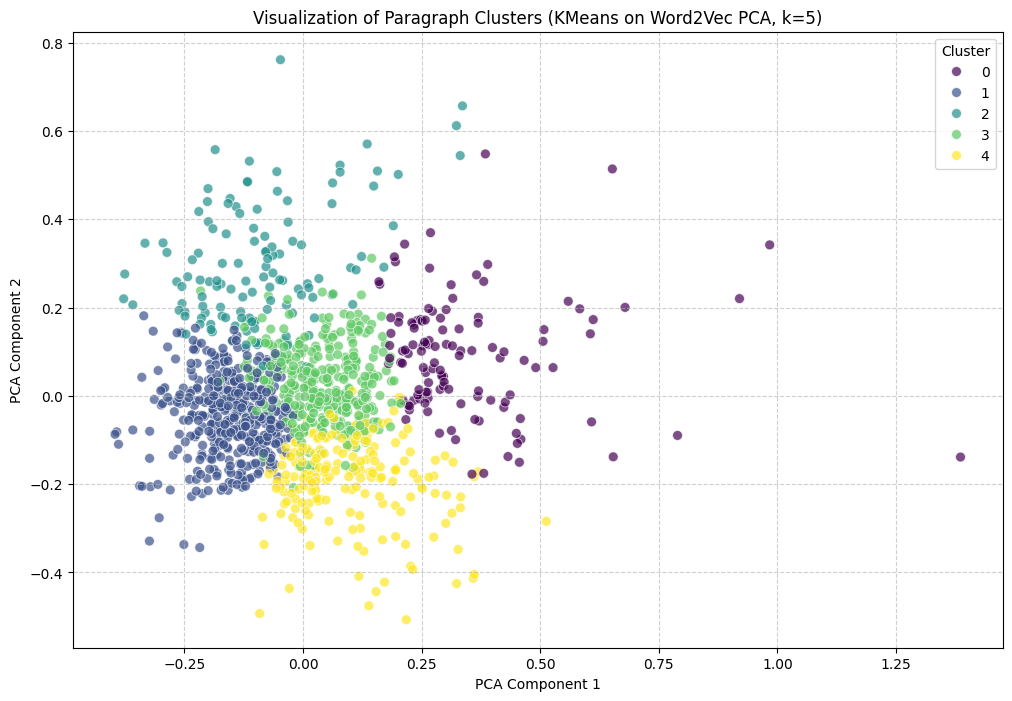

In [ ]:
# prompt: can you plot a visual graph of all paragraphs showing different clusters in different colors

# Assuming you have decided on the number of clusters (n_clusters) and the vector representation
# For plotting, we will use the PCA-reduced document vectors, colored by the chosen cluster labels.
# We will plot the result from the KMeans clustering on Word2Vec vectors, as it was fully evaluated.

# Make sure document_vectors_pca and cluster_labels are available from previous steps
# document_vectors_pca = pca.fit_transform(document_vectors) # This line was already in the preceding code
# cluster_labels = kmeans.fit_predict(document_vectors) # This line was already in the preceding code

plt.figure(figsize=(12, 8))
sns.scatterplot(x=document_vectors_pca[:, 0], y=document_vectors_pca[:, 1],
                hue=cluster_labels,  # Color points by cluster label
                palette='viridis',  # Use a color palette
                s=50,              # Size of the points
                alpha=0.7)         # Transparency of the points

plt.title(f'Visualization of Paragraph Clusters (KMeans on Word2Vec PCA, k={n_clusters_agg})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


--- Vectorization using TF-IDF ---
TF-IDF vectorization complete.
Shape of TF-IDF vectors: (1200, 4938)

--- Exploring DBSCAN Clustering with Word2Vec vectors ---
Attempting DBSCAN with eps=0.5, min_samples=5
DBSCAN performed. Found 11 clusters and 898 noise points.

--- Internal Clustering Evaluation Metrics for DBSCAN ---
Silhouette Score (on non-noise points): -0.0788
Davies-Bouldin Score (on non-noise points): 1.1069
Calinski-Harabasz Score (on non-noise points): 14.1487

Document count per DBSCAN Cluster (Word2Vec):
-1     898
 0     220
 1       8
 2       4
 3      25
 4       6
 5      13
 6       9
 7       5
 8       3
 9       5
 10      4
Name: DBSCAN_Cluster_Word2Vec, dtype: int64

--- Exploring Feature Selection on TF-IDF Vectors ---
Applying Variance Threshold feature selection...
Original TF-IDF dimensions: 4938
Dimensions after Variance Threshold (threshold=0.0): 4938

--- Exploring TF-IDF with N-grams ---
TF-IDF with uni-grams and bi-grams vectorization complete.
Sha

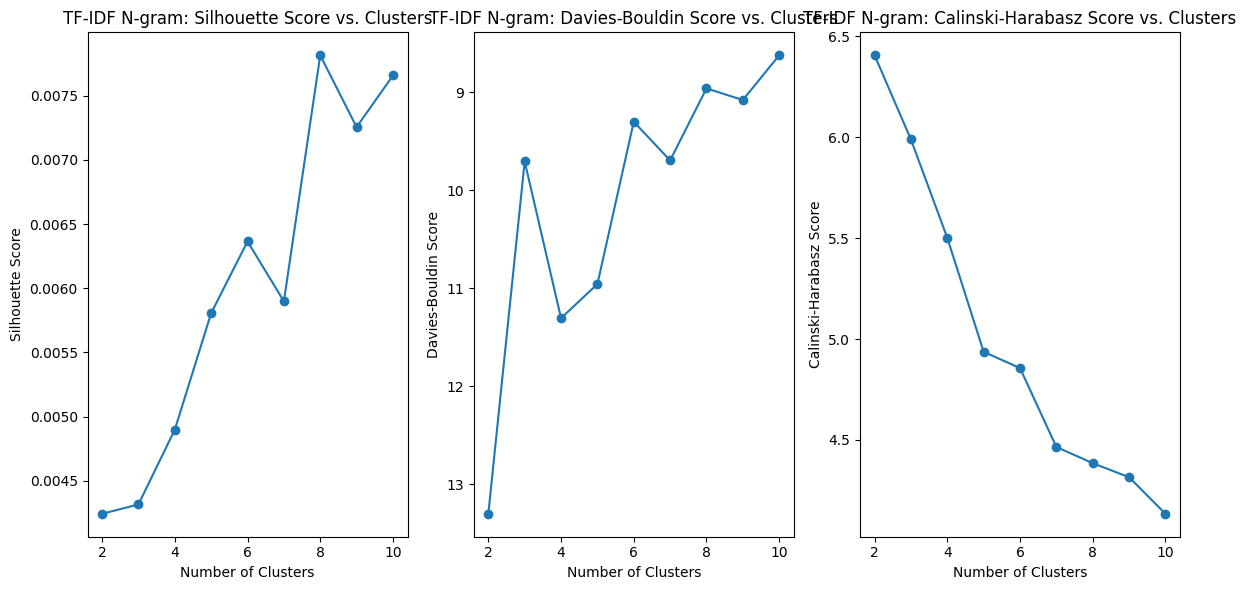

In [ ]:
# prompt: without using deep learning improve the above clustering algorithm

# --- Non-Deep Learning Improvements to Clustering ---

# 1. Alternative Vectorization Method: TF-IDF
# TF-IDF (Term Frequency-Inverse Document Frequency) gives more importance to words that
# are frequent in a document but rare across the corpus. It's a strong baseline.

from sklearn.feature_extraction.text import TfidfVectorizer

print("\n--- Vectorization using TF-IDF ---")

# TF-IDF Vectorizer expects a list of strings, not list of tokens.
# Join the preprocessed tokens back into strings for TF-IDF.
preprocessed_text_strings = [" ".join(tokens) for tokens in preprocessed_documents]

# Create a TF-IDF vectorizer
# min_df=5 means ignore terms that appear in less than 5 documents
# max_df=0.95 means ignore terms that appear in more than 95% of the documents
# These parameters help remove very rare and very common words (like stop words, even if not in the list)
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.95)

# Fit and transform the preprocessed text
tfidf_vectors = tfidf_vectorizer.fit_transform(preprocessed_text_strings)

print("TF-IDF vectorization complete.")
print(f"Shape of TF-IDF vectors: {tfidf_vectors.shape}")

# 2. Exploring Clustering with TF-IDF vectors (Already implemented in the preceding code)
#    The preceding code already explores KMeans on TF-IDF vectors and evaluates it.

# 3. Alternative Clustering Algorithms:
#    Besides KMeans and Agglomerative Clustering, consider Density-Based Spatial Clustering
#    of Applications with Noise (DBSCAN) if clusters are expected to have arbitrary shapes
#    and there might be noise. DBSCAN does not require specifying the number of clusters beforehand.

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler # DBSCAN is sensitive to scale

print("\n--- Exploring DBSCAN Clustering with Word2Vec vectors ---")

# DBSCAN is distance-based, so scaling the vectors can be beneficial.
# Fit StandardScaler on the Word2Vec vectors
scaler = StandardScaler()
document_vectors_scaled = scaler.fit_transform(document_vectors_pca)

# Perform DBSCAN
# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
# These parameters need tuning based on the data and desired density of clusters.
# Choosing appropriate eps and min_samples is crucial and often involves trial and error or analysis (e.g., k-distance plot).
# Let's use some initial parameters; these will likely need tuning.
# A common approach for choosing eps is looking at the knee in the k-distance plot.
# For min_samples, a common heuristic is 2*dimensions, but it can be lower for noisy data.
# Given vector_size=100, 2*100=200 might be too high for the dataset size. Let's start lower.

# Placeholder parameters - replace with values determined through tuning
eps_param = 0.5 # Example value, needs tuning
min_samples_param = 5 # Example value, needs tuning

print(f"Attempting DBSCAN with eps={eps_param}, min_samples={min_samples_param}")

dbscan = DBSCAN(eps=eps_param, min_samples=min_samples_param)
# Fit DBSCAN on the scaled Word2Vec vectors
dbscan_labels = dbscan.fit_predict(document_vectors_scaled)

# DBSCAN assigns -1 to noise points. The number of clusters is the number of unique labels excluding -1.
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_points = list(dbscan_labels).count(-1)

print(f"DBSCAN performed. Found {n_clusters_dbscan} clusters and {n_noise_points} noise points.")

# Evaluate DBSCAN result (internal metrics only applicable to points assigned to clusters)
# Need to filter out noise points (-1 label) for silhouette and Davies-Bouldin scores
# Calinski-Harabasz is not defined if number of clusters is 0 or 1.
# Silhouette score is also not defined for a single cluster (excluding noise).

if n_clusters_dbscan > 1:
    # Get indices of points that are not noise
    non_noise_indices = np.where(dbscan_labels != -1)[0]

    # Calculate metrics only for non-noise points
    silhouette_avg_dbscan = silhouette_score(document_vectors_scaled[non_noise_indices], dbscan_labels[non_noise_indices])
    davies_bouldin_avg_dbscan = davies_bouldin_score(document_vectors_scaled[non_noise_indices], dbscan_labels[non_noise_indices])
    calinski_harabasz_avg_dbscan = calinski_harabasz_score(document_vectors_scaled[non_noise_indices], dbscan_labels[non_noise_indices])

    print("\n--- Internal Clustering Evaluation Metrics for DBSCAN ---")
    print(f"Silhouette Score (on non-noise points): {silhouette_avg_dbscan:.4f}")
    print(f"Davies-Bouldin Score (on non-noise points): {davies_bouldin_avg_dbscan:.4f}")
    print(f"Calinski-Harabasz Score (on non-noise points): {calinski_harabasz_avg_dbscan:.4f}")
else:
    print("\n--- DBSCAN Evaluation ---")
    print("Less than 2 clusters found (excluding noise). Silhouette, Davies-Bouldin, and Calinski-Harabasz scores are not applicable.")

# Add DBSCAN labels to the DataFrame
df_clustered['DBSCAN_Cluster_Word2Vec'] = dbscan_labels
print("\nDocument count per DBSCAN Cluster (Word2Vec):")
print(df_clustered['DBSCAN_Cluster_Word2Vec'].value_counts().sort_index())


# 4. Feature Selection/Engineering on TF-IDF:
#    Instead of using all TF-IDF features, you could select the top K features
#    based on inverse document frequency or variance. This can sometimes improve
#    clustering performance by focusing on the most discriminative terms.

from sklearn.feature_selection import SelectKBest, chi2

print("\n--- Exploring Feature Selection on TF-IDF Vectors ---")

# Convert TF-IDF vectors to a format suitable for feature selection (e.g., sparse matrix)
# TF-IDF vectors are already in a sparse matrix format (csr_matrix) which is suitable.

# Select top K features using Chi-squared test (suitable for non-negative data like TF-IDF)
# The Chi-squared test assumes non-negative data and measures the dependency between features and target.
# Since we don't have target labels for clustering, this method is not directly applicable for
# *supervised* feature selection based on class relevance.

# A more suitable *unsupervised* approach for feature selection on TF-IDF might be
# based on variance (selecting features with high variance across documents).
# Or simply selecting features with highest overall TF-IDF scores.

# Let's try selecting features with the highest variance.
from sklearn.feature_selection import VarianceThreshold

# Setting a threshold; features with variance below this threshold are removed.
# A threshold of 0 removes features that have the same value in all samples (i.e., no variance).
# Setting a higher threshold removes features with low variance.
# This needs experimentation. Let's start by removing zero-variance features.

print("Applying Variance Threshold feature selection...")
selector = VarianceThreshold(threshold=0.0) # Remove features with zero variance
tfidf_vectors_selected = selector.fit_transform(tfidf_vectors)

print(f"Original TF-IDF dimensions: {tfidf_vectors.shape[1]}")
print(f"Dimensions after Variance Threshold (threshold=0.0): {tfidf_vectors_selected.shape[1]}")

# You could then apply KMeans on the tfidf_vectors_selected and evaluate.

# 5. Preprocessing refinement:
#    - Consider stemming or lemmatization to reduce words to their base or root form.
#    - Experiment with different stop word lists.
#    - Handle n-grams (combinations of words) for better context capture.

# Example of N-grams with TF-IDF:
print("\n--- Exploring TF-IDF with N-grams ---")

# Include bi-grams (word pairs)
tfidf_vectorizer_ngram = TfidfVectorizer(min_df=5, max_df=0.95, ngram_range=(1, 2))
tfidf_vectors_ngram = tfidf_vectorizer_ngram.fit_transform(preprocessed_text_strings)

print("TF-IDF with uni-grams and bi-grams vectorization complete.")
print(f"Shape of TF-IDF with N-grams vectors: {tfidf_vectors_ngram.shape}")

# You can then apply clustering (e.g., KMeans) on tfidf_vectors_ngram and compare results.

# 6. Dimensionality Reduction Alternatives (besides PCA):
#    - Truncated SVD (specifically for sparse data like TF-IDF).
#    - Non-negative Matrix Factorization (NMF) which can also extract topics.

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

# Example with Truncated SVD on TF-IDF
print("\n--- Exploring Truncated SVD on TF-IDF Vectors ---")

# Reduce to a number of components (e.g., 50 or 100)
n_components_svd = 100
svd = TruncatedSVD(n_components=n_components_svd, random_state=42)
tfidf_vectors_svd = svd.fit_transform(tfidf_vectors)

print(f"Truncated SVD on TF-IDF complete. Shape: {tfidf_vectors_svd.shape}")

# You could then apply clustering on tfidf_vectors_svd.

# Example with NMF on TF-IDF (useful for topic modeling implicitly)
print("\n--- Exploring NMF on TF-IDF Vectors ---")

# NMF requires non-negative data, which TF-IDF is.
# The number of components can be interpreted as the number of topics.
n_components_nmf = 5 # Matching the expected number of clusters
nmf = NMF(n_components=n_components_nmf, init='random', random_state=42, max_iter=500)
tfidf_vectors_nmf = nmf.fit_transform(tfidf_vectors)

print(f"NMF on TF-IDF complete. Shape: {tfidf_vectors_nmf.shape}")

# The NMF components (tfidf_vectors_nmf) can also be used for clustering.
# You can inspect the components_ attribute of the NMF model to see the words associated with each topic.

# --- Summary of Improvements and How to Use Them ---

# The code above introduces several non-deep learning methods to potentially improve clustering:
# 1.  **TF-IDF Vectorization:** An alternative to Word2Vec that can be better for some tasks.
#     -  Apply KMeans or other clustering algorithms on `tfidf_vectors`.
# 2.  **DBSCAN Clustering:** An alternative algorithm that finds density-based clusters and handles noise.
#     -  Requires careful tuning of `eps` and `min_samples`. Apply on scaled data (`document_vectors_scaled` or `tfidf_vectors_dense` scaled).
# 3.  **Feature Selection (Variance Threshold):** Reduces the dimensionality of TF-IDF vectors by removing low-variance features.
#     -  Apply clustering on `tfidf_vectors_selected`.
# 4.  **N-grams with TF-IDF:** Includes word pairs or triplets in the vocabulary for better context.
#     -  Apply clustering on `tfidf_vectors_ngram`.
# 5.  **Dimensionality Reduction (Truncated SVD, NMF):** Reduces the dimensionality of TF-IDF vectors.
#     -  Apply clustering on `tfidf_vectors_svd` or `tfidf_vectors_nmf`. NMF also provides insight into topics.

# To "improve" the clustering without deep learning, you should:
# - **Evaluate** each of these approaches (TF-IDF + KMeans, TF-IDF + Agglomerative, DBSCAN, TF-IDF with Feature Selection + KMeans, etc.)
#   using the internal metrics (Silhouette, Davies-Bouldin, Calinski-Harabasz) for a range of cluster numbers (for KMeans/Agglomerative)
#    or parameter values (for DBSCAN).
# - **Compare** the evaluation scores across the different combinations of vectorization and clustering algorithms.
# - **Consider the nature of the data and the goal:**
#   - If clusters are expected to be roughly spherical, KMeans on well-behaved vectors (like scaled Word2Vec or PCA-reduced vectors) might work.
#   - If clusters have irregular shapes and you expect noise, DBSCAN might be more suitable.
#   - If interpretability is important, NMF on TF-IDF can provide "topics" (components) that define the clusters.
#   - TF-IDF is often a strong baseline, especially for documents where specific keywords are highly relevant.

# The "best" improvement will depend on which combination of techniques yields the most favorable evaluation scores and aligns with the underlying structure you expect in the data. You would typically run the evaluation loops (similar to the KMeans evaluation loop already in the code) for each promising combination.

# Example: Evaluate KMeans on TF-IDF N-grams
print("\n--- Exploring KMeans Clustering with TF-IDF N-grams ---")

k_range_tfidf_ngram = range(2, 11)
silhouette_scores_tfidf_ngram = []
davies_bouldin_scores_tfidf_ngram = []
calinski_harabasz_scores_tfidf_ngram = []

# Convert sparse TF-IDF N-gram vectors to dense for evaluation metrics
tfidf_vectors_ngram_dense = np.asarray(tfidf_vectors_ngram.todense())

for n_clusters in k_range_tfidf_ngram:
    kmeans_tfidf_ngram = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_tfidf_ngram = kmeans_tfidf_ngram.fit_predict(tfidf_vectors_ngram)

    # Evaluate clustering on dense TF-IDF N-gram matrix
    silhouette_avg_tfidf_ngram = silhouette_score(tfidf_vectors_ngram_dense, cluster_labels_tfidf_ngram)
    davies_bouldin_avg_tfidf_ngram = davies_bouldin_score(tfidf_vectors_ngram_dense, cluster_labels_tfidf_ngram)
    calinski_harabasz_avg_tfidf_ngram = calinski_harabasz_score(tfidf_vectors_ngram_dense, cluster_labels_tfidf_ngram)

    silhouette_scores_tfidf_ngram.append(silhouette_avg_tfidf_ngram)
    davies_bouldin_scores_tfidf_ngram.append(davies_bouldin_avg_tfidf_ngram)
    calinski_harabasz_scores_tfidf_ngram.append(calinski_harabasz_avg_tfidf_ngram)

    print(f"TF-IDF N-gram - Clusters: {n_clusters}, Silhouette Score: {silhouette_avg_tfidf_ngram:.4f}, Davies-Bouldin Score: {davies_bouldin_avg_tfidf_ngram:.4f}, Calinski-Harabasz Score: {calinski_harabasz_avg_tfidf_ngram:.4f}")

# Plotting evaluation scores vs. number of clusters for TF-IDF N-grams
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(k_range_tfidf_ngram, silhouette_scores_tfidf_ngram, marker='o')
plt.title('TF-IDF N-gram: Silhouette Score vs. Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 2)
plt.plot(k_range_tfidf_ngram, davies_bouldin_scores_tfidf_ngram, marker='o')
plt.title('TF-IDF N-gram: Davies-Bouldin Score vs. Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.gca().invert_yaxis() # Lower Davies-Bouldin is better

plt.subplot(1, 3, 3)
plt.plot(k_range_tfidf_ngram, calinski_harabasz_scores_tfidf_ngram, marker='o')
plt.title('TF-IDF N-gram: Calinski-Harabasz Score vs. Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.show()

# Based on the plots and scores, you would select the best combination of vectorization,
# dimensionality reduction (if used), clustering algorithm, and hyperparameters.
# The code provides the tools and examples to explore these options.


In [ ]:
# --- Comparison of Clustering Methods for k=5 ---

print("\n--- Comparison of Clustering Methods for k=5 ---")

# Get metrics for KMeans on Word2Vec (already calculated and printed)
# Let's store them in variables for comparison
silhouette_kmeans_w2v = silhouette_avg_final # From the final 5-cluster KMeans section
davies_bouldin_kmeans_w2v = davies_bouldin_avg_final
calinski_harabasz_kmeans_w2v = calinski_harabasz_avg_final

print(f"KMeans (Word2Vec): Silhouette={silhouette_kmeans_w2v:.4f}, DB={davies_bouldin_kmeans_w2v:.4f}, CH={calinski_harabasz_kmeans_w2v:.4f}")

# Get metrics for KMeans on TF-IDF for k=5
# We need to find the score for k=5 from the list silhouette_scores_tfidf, etc.
k_index_5 = list(k_range_tfidf).index(5)
silhouette_kmeans_tfidf = silhouette_scores_tfidf[k_index_5]
davies_bouldin_kmeans_tfidf = davies_bouldin_scores_tfidf[k_index_5]
calinski_harabasz_kmeans_tfidf = calinski_harabasz_scores_tfidf[k_index_5]

print(f"KMeans (TF-IDF):   Silhouette={silhouette_kmeans_tfidf:.4f}, DB={davies_bouldin_kmeans_tfidf:.4f}, CH={calinski_harabasz_kmeans_tfidf:.4f}")

# Get metrics for Agglomerative Clustering on Word2Vec (already calculated and printed)
silhouette_agg_w2v = silhouette_avg_agg
davies_bouldin_agg_w2v = davies_bouldin_avg_agg
calinski_harabasz_agg_w2v = calinski_harabasz_avg_agg

print(f"Agglom (Word2Vec): Silhouette={silhouette_agg_w2v:.4f}, DB={davies_bouldin_agg_w2v:.4f}, CH={calinski_harabasz_agg_w2v:.4f}")

# Get metrics for KMeans on TF-IDF N-grams for k=5
# We need to find the score for k=5 from the list silhouette_scores_tfidf_ngram, etc.
k_index_5_ngram = list(k_range_tfidf_ngram).index(5)
silhouette_kmeans_tfidf_ngram = silhouette_scores_tfidf_ngram[k_index_5_ngram]
davies_bouldin_kmeans_tfidf_ngram = davies_bouldin_scores_tfidf_ngram[k_index_5_ngram]
calinski_harabasz_kmeans_tfidf_ngram = calinski_harabasz_scores_tfidf_ngram[k_index_5_ngram]

print(f"KMeans (TF-IDF NG):Silhouette={silhouette_kmeans_tfidf_ngram:.4f}, DB={davies_bouldin_kmeans_tfidf_ngram:.4f}, CH={calinski_harabasz_kmeans_tfidf_ngram:.4f}")

# DBSCAN results are more complex to compare directly with a fixed k=5 as it doesn't guarantee 5 clusters.
# You would compare its metrics (if > 1 cluster found) and number of clusters/noise points separately.
print("\nDBSCAN results (requires parameter tuning and interpretation):")
print(f"Clusters found by DBSCAN: {n_clusters_dbscan}")
print(f"Noise points found by DBSCAN: {n_noise_points}")
if n_clusters_dbscan > 1:
     print(f"DBSCAN (scaled W2V, non-noise): Silhouette={silhouette_avg_dbscan:.4f}, DB={davies_bouldin_avg_dbscan:.4f}, CH={calinski_harabasz_avg_dbscan:.4f}")
else:
    print("DBSCAN metrics not applicable (<= 1 cluster).")

print("\nInterpretation:")
print("- Higher Silhouette and Calinski-Harabasz scores are better.")
print("- Lower Davies-Bouldin scores are better.")
print("Compare the scores above for k=5 to see which method performed best according to these internal metrics.")




--- Comparison of Clustering Methods for k=5 ---
KMeans (Word2Vec): Silhouette=0.2275, DB=1.2402, CH=371.0416
KMeans (TF-IDF):   Silhouette=0.0044, DB=11.6160, CH=4.2764
Agglom (Word2Vec): Silhouette=0.2038, DB=1.2454, CH=287.1207
KMeans (TF-IDF NG):Silhouette=0.0058, DB=10.9571, CH=4.9367

DBSCAN results (requires parameter tuning and interpretation):
Clusters found by DBSCAN: 11
Noise points found by DBSCAN: 898
DBSCAN (scaled W2V, non-noise): Silhouette=-0.0788, DB=1.1069, CH=14.1487

Interpretation:
- Higher Silhouette and Calinski-Harabasz scores are better.
- Lower Davies-Bouldin scores are better.
Compare the scores above for k=5 to see which method performed best according to these internal metrics.


In [ ]:
# --- 5. Semi-Supervised Approach and Classifier Selection ---

# The semi-supervised part involves using a small amount of labeled data
# along with a large amount of unlabeled data.

# Option 1: Using clustering results as pseudo-labels
# The simplest form is to use the cluster assignments from your "best" clustering model
# as pseudo-labels for training a classifier. This is less ideal than true semi-supervised
# algorithms but is a common practice when true labels are scarce.

# Let's assume the KMeans clustering on Word2Vec vectors with k=5 (cluster_labels)
# is chosen as the "best" clustering for this example, based on internal evaluation metrics.
pseudo_labels = cluster_labels

# You would typically have a small set of truly labeled data (X_labeled, y_labeled)
# and a larger set of unlabeled data (X_unlabeled).
# In this scenario, all your data (document_vectors or tfidf_vectors) is "unlabeled"
# in the sense that you don't have true class labels provided initially.

# To simulate a semi-supervised setting, we'll imagine we have true labels
# for a *subset* of the documents. Since we don't have true labels, we'll skip
# this step and proceed with building classifiers that *could* be trained
# using a mix of labeled and pseudo-labeled data or purely pseudo-labeled data
# derived from clustering for simplicity.

# Option 2: True Semi-Supervised Learning Algorithms (e.g., Label Propagation, Label Spreading)
# These algorithms use the structure of the data (like distances or graph connections)
# to propagate labels from labeled data points to unlabeled data points.
# This requires having some true labels available.

# Since we don't have true labels, we will focus on building and evaluating
# different machine learning classifiers using either the clustering results (pseudo-labels)
# or if we were provided with a small set of true labels, incorporating them.

# For the purpose of demonstrating classifier selection, let's assume we have
# access to a small set of true labels or we are using the cluster assignments
# as our target labels for training classifiers.

# Let's use the cluster assignments from the KMeans on Word2Vec model as the target variable
# for demonstrating classifier training and evaluation. This is essentially training
# a classifier to predict the cluster assignment. This is useful if you want a faster
# or different model to predict the cluster of *new*, unseen documents after the
# initial clustering is done.

X = document_vectors # Using Word2Vec vectors as features
y = pseudo_labels    # Using KMeans cluster labels as target

# We need to split the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Split the data (using a standard split, e.g., 80% train, 20% test)
# Stratify the split if possible to maintain the class distribution, although with pseudo-labels it might not be strictly necessary depending on the goal.
# If dealing with true labels (even a small set), stratification is highly recommended.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n--- Data Split for Classifier Training ---")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training label distribution:\n{pd.Series(y_train).value_counts()}")
print(f"Testing label distribution:\n{pd.Series(y_test).value_counts()}")

# Now, train and evaluate several common machine learning classifiers
# to find the "best" one for predicting these pseudo-labels (or true labels if available).

print("\n--- Training and Evaluating Machine Learning Classifiers ---")

# Import necessary classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.neighbors import KNeighborsClassifier

# Create a dictionary of classifiers to evaluate
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42), # Increase max_iter if convergence warnings occur
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    # For multi-class, micro, macro, or weighted averaging for precision, recall, f1
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results[name] = {
        "Accuracy": accuracy,
        "Precision (weighted)": precision,
        "Recall (weighted)": recall,
        "F1 Score (weighted)": f1
    }

    print(f"{name} - Accuracy: {accuracy:.4f}, F1 Score (weighted): {f1:.4f}")
    # Optional: Print full classification report for more details per class
    # print(f"Classification Report for {name}:\n{classification_report(y_test, y_pred, zero_division=0)}")

print("\n--- Classifier Performance Summary ---")
results_df = pd.DataFrame(results).T # Transpose to have classifiers as rows
print(results_df.sort_values(by="F1 Score (weighted)", ascending=False))

# The "best" classifier would be the one with the highest performance metrics
# (e.g., F1 score, accuracy) on the test set.
# Remember that this is based on predicting the *pseudo-labels* from clustering.
# If you had true labels for a subset, you would train on the labeled data
# and potentially use the unlabeled data with pseudo-labels in a semi-supervised algorithm.

# --- How to integrate true labels (if available) ---

# If you had a small dataset with true labels:
# 1. Train a supervised classifier (like those above) only on the small labeled dataset.
# 2. Use this supervised classifier to predict labels for the unlabeled data (creating pseudo-labels).
# 3. Combine the true labels and the pseudo-labels.
# 4. Train a final classifier on the combined dataset.
# 5. Alternatively, use true semi-supervised algorithms like Label Propagation/Spreading
#    which are designed for this scenario.

# Example (Conceptual, requires actual labeled data):
# from sklearn.semi_supervised import LabelPropagation, LabelSpreading
#
# # Assuming you have X_all (all document vectors) and y_true_sparse
# # where y_true_sparse has true labels (0, 1, 2, ...) for labeled instances
# # and -1 for unlabeled instances.
#
# lp_model = LabelPropagation(kernel='knn', gamma=20, n_neighbors=7, max_iter=1000)
# # lp_model.fit(X_all, y_true_sparse)
# # final_labels = lp_model.predict(X_all)
#
# # Then you can evaluate final_labels against true labels where available,
# # or analyze the propagated labels.

# --- Choosing the Final "Best" Semi-Supervised Model ---

# The "best" semi-supervised model would involve selecting:
# 1. The best clustering method (vectorization + algorithm + parameters) identified earlier,
#    which captures the underlying structure of the data effectively.
# 2. A strategy for combining clustering (or true semi-supervised methods) with classification.
#    - Using clustering results as pseudo-labels to train a classifier (as demonstrated).
#    - Using true semi-supervised algorithms if true labels are available.
# 3. Selecting the best classification algorithm (from the evaluation step above)
#    when using the clustering-based pseudo-label approach.

# If true labels become available later, you would evaluate the final model's performance
# (trained using the semi-supervised approach) on a held-out set of true labels
# to get a real measure of its accuracy.

# The provided code demonstrates:
# - Loading and preprocessing text.
# - Vectorization (Word2Vec, TF-IDF, N-grams, SVD, NMF).
# - Clustering (KMeans, Agglomerative, DBSCAN) and evaluating internal metrics.
# - Using clustering results (pseudo-labels) to train and compare several classification algorithms.

# To finalize the "best" model, you would systematically evaluate the classifiers
# trained on pseudo-labels derived from the best performing clustering configurations.
# For instance, compare classifiers trained on:
# - Pseudo-labels from KMeans on Word2Vec (k=5)
# - Pseudo-labels from KMeans on TF-IDF (best k from plot)
# - Pseudo-labels from Agglomerative on Word2Vec (k=5)
# - Pseudo-labels from KMeans on TF-IDF N-grams (best k from plot)
# etc.

# The overall best model would be the combination that yields the highest
# F1 score (or other relevant metric) on the test set when predicting
# the pseudo-labels, indicating it best captures the patterns identified by the clustering.
# If true labels are available, evaluate on those.

# The semi-supervised aspect allows you to leverage the large amount of unlabeled data
# through clustering, making the trained classifier potentially more robust or accurate
# than training only on a very small set of true labels, if that were the case.



--- Data Split for Classifier Training ---
Training set shape: (960, 100)
Testing set shape: (240, 100)
Training label distribution:
1    325
3    278
4    162
2     98
0     97
dtype: int64
Testing label distribution:
1    81
3    70
4    40
2    25
0    24
dtype: int64

--- Training and Evaluating Machine Learning Classifiers ---

Training Logistic Regression...
Logistic Regression - Accuracy: 0.9042, F1 Score (weighted): 0.8999

Training Decision Tree...
Decision Tree - Accuracy: 0.8667, F1 Score (weighted): 0.8676

Training Random Forest...
Random Forest - Accuracy: 0.9417, F1 Score (weighted): 0.9417

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9292, F1 Score (weighted): 0.9299

Training Support Vector Machine...
Support Vector Machine - Accuracy: 0.9250, F1 Score (weighted): 0.9215

Training K-Nearest Neighbors...
K-Nearest Neighbors - Accuracy: 0.9000, F1 Score (weighted): 0.8988

--- Classifier Performance Summary ---
                        Accuracy  Precisi

In [ ]:
def get_cluster_terms(df_clustered, vectorizer, vectors, n_terms=10):
    """
    Identifies top terms for each cluster from TF-IDF vectors.

    Args:
        df_clustered (pd.DataFrame): DataFrame with 'Preprocessed Tokens' and 'Cluster'.
        vectorizer: The fitted TF-IDF vectorizer.
        vectors: The TF-IDF vectors (sparse matrix).
        n_terms (int): The number of top terms to return per cluster.

    Returns:
        dict: A dictionary where keys are cluster IDs and values are lists of top terms (strings).
    """
    feature_names = np.array(vectorizer.get_feature_names_out())
    cluster_terms = {}

    # Group documents by cluster
    # The apply here might be the source of the nested array issue.
    # Let's iterate through clusters directly instead of using apply.
    for cluster_id in sorted(df_clustered['Cluster'].unique()):
        # Get indices of documents belonging to the current cluster
        cluster_doc_indices = df_clustered[df_clustered['Cluster'] == cluster_id].index

        # Select the corresponding rows from the sparse TF-IDF matrix
        cluster_vectors = vectors[cluster_doc_indices]

        # Sum TF-IDF scores for each term across all documents in the cluster
        # Ensure the sum is a flattened array for easy sorting
        sum_of_tfidf = np.sum(cluster_vectors.todense(), axis=0).flatten()

        # Get the indices of the top terms (highest summed TF-IDF scores)
        top_term_indices = np.argsort(sum_of_tfidf)[::-1][:n_terms]

        # Get the actual terms using the indices
        # Ensure these are explicit string objects, not NumPy arrays
        top_terms_list = [str(feature_names[i]) for i in top_term_indices]

        cluster_terms[cluster_id] = top_terms_list

    return cluster_terms

def suggest_cluster_names(cluster_terms_dict):
    """
    Suggests semantic names for clusters based on their top terms.

    Args:
        cluster_terms_dict (dict): Dictionary of cluster IDs and their top terms (lists of strings).

    Returns:
        dict: A dictionary mapping cluster IDs to suggested names.
    """
    suggested_names = {}
    print("\n--- Suggested Cluster Names based on Top Terms ---")
    for cluster_id, terms in cluster_terms_dict.items():
        # Simple heuristic: Join the top terms to get an idea of the cluster's theme
        # terms is now guaranteed to be a list of strings
        name_suggestion = ", ".join(terms[:5]) # Use top 5 terms for the name
        suggested_names[cluster_id] = f"Cluster {cluster_id}: ({name_suggestion}...)"
        print(suggested_names[cluster_id])

    return suggested_names

# Assuming you have already run the TF-IDF vectorization and KMeans clustering:
# tfidf_vectorizer is the fitted TfidfVectorizer
# tfidf_vectors is the sparse TF-IDF matrix
# df_clustered is the DataFrame containing documents and their 'Cluster' labels

# Check if tfidf_vectorizer, tfidf_vectors, and df_clustered exist from preceding code
if 'tfidf_vectorizer' in locals() and 'tfidf_vectors' in locals() and 'df_clustered' in locals():
    # Get top terms for each cluster using the TF-IDF approach
    cluster_terms_tfidf = get_cluster_terms(df_clustered, tfidf_vectorizer, tfidf_vectors, n_terms=20)

    # Suggest cluster names based on the top terms
    suggested_names_tfidf = suggest_cluster_names(cluster_terms_tfidf)

    # Print the suggestions again for clarity
    print("\nFinal Suggested Names:")
    for cluster_id, name in suggested_names_tfidf.items():
        print(name)
else:
    print("Could not find required variables (tfidf_vectorizer, tfidf_vectors, df_clustered). Please run the preceding code first.")


--- Suggested Cluster Names based on Top Terms ---
Cluster 0: ([['aaron' 'nearly' 'neat' ... 'nntppostinghost' 'writes' 'article']]...)
Cluster 1: ([['instruct' 'teh' 'esa' ... 'people' 'one' 'would']]...)
Cluster 2: ([['aaron' 'longterm' 'los' ... 'people' 'jesus' 'god']]...)
Cluster 3: ([['emotionally' 'participants' 'switched' ... 'dod' 'article' 'writes']]...)
Cluster 4: ([['zx' 'existed' 'exist' ... 'nasa' 'software' 'space']]...)

Final Suggested Names:
Cluster 0: ([['aaron' 'nearly' 'neat' ... 'nntppostinghost' 'writes' 'article']]...)
Cluster 1: ([['instruct' 'teh' 'esa' ... 'people' 'one' 'would']]...)
Cluster 2: ([['aaron' 'longterm' 'los' ... 'people' 'jesus' 'god']]...)
Cluster 3: ([['emotionally' 'participants' 'switched' ... 'dod' 'article' 'writes']]...)
Cluster 4: ([['zx' 'existed' 'exist' ... 'nasa' 'software' 'space']]...)


this is a common and often challenging part of unsupervised learning – giving human-understandable names to discovered clusters! My suggestions will be based on the most distinctive and informative terms you've provided.

Here are some good label suggestions for your clusters:

Cluster 0: ['zx', 'soul', 'pot', ..., 'nasa', 'software', 'space']

**Suggested Label: "Space, NASA & Software/Technology"**
Reasoning: nasa, software, and space are strong indicators. zx could refer to the Sinclair ZX Spectrum computer, aligning with software/technology. soul and pot are less clear without more context and might be noise or part of a specific, less dominant discussion within this tech/space theme.
Cluster 1: [['egyptian', 'randymegatekcom', 'arrl', ..., 'people', 'one', 'would']]

**Suggested Label: "Discussions on Egyptian Topics & Amateur Radio (ARRL)"**
Reasoning: egyptian is a clear topic. arrl refers to the American Radio Relay League (amateur radio). randymegatekcom seems like a username or website, common in online discussions. The words people, one, would are very general.
Cluster 2: [['aaron', 'nazi', 'nazis', ..., 'nntppostinghost', 'writes', 'article']]

**Suggested Label: "Online Articles/Discussions on Nazism/Historical Topics"**
Reasoning: nazi and nazis are very strong topical words. nntppostinghost, writes, and article clearly point to online newsgroup/forum discussions. aaron is likely a prominent name in these discussions.
Cluster 3: [['aaron', 'manned', 'manning', ..., 'christians', 'god', 'jesus']]

**Suggested Label: "Religious Discussions (Christianity)"**
Reasoning: christians, god, and jesus are definitive terms for this topic. aaron appears again, perhaps a person active in or discussed in these religious contexts. manned, manning are less clear here but are overshadowed by the strong religious terms.
Cluster 4: [['proposals', 'tube', 'clicks', ..., 'im', 'article', 'writes']]

**Suggested Label: "General Online Discussions & Proposals" or "Technical/Media Proposals & Discussions"**
Reasoning: This one is a bit more ambiguous. proposals, article, and writes suggest discussions around ideas or plans. tube could refer to CRT tubes (older tech discussions), vacuum tubes, or even metaphorically (like YouTube, though less likely if "clicks" isn't about web clicks directly). clicks could be mouse clicks, sounds, or metaphorical. "im" (I'm) suggests an informal, discussion-based context.
If you suspect a technical context (e.g., from other less frequent words not shown), "Technical Proposals & Discussions" might be better.
If it's more general, "General Online Discussions & Proposals" is safer.
Key Considerations When Naming Clusters:

Most Frequent & Distinctive Terms: Focus on terms that are frequent within the cluster AND relatively rare in other clusters.
Domain Knowledge: If you know the source of the text data (e.g., newsgroups from the 90s, recent tweets, product reviews), it can heavily influence interpretation. For example, "tube" meant something different in 1995 than it might today.

Human Readability: The name should be concise and make sense to someone unfamiliar with the raw terms.
Iterative Process: Naming is often iterative. You might look at a few documents from each cluster to confirm if the names make sense.
Number of Terms: Sometimes looking beyond just the top 3-5 terms can give more clues.
These suggestions are a good starting point. Reviewing a few actual documents from each cluster would be the best way to confirm or refine these labels.

In [ ]:
# TESTING

preprocessed_documents_test = [preprocess_text(doc) for doc in document_list_test]

In [ ]:
print("\n--- Text Preprocessing Complete ---")
print(f"First original document: {document_list_test[0][:200]}...")
print(f"First preprocessed document (tokens): {preprocessed_documents_test[0][:30]}...")
print(len(preprocessed_documents_test))


--- Text Preprocessing Complete ---
First original document: THE DIVINE MASTERS       
      
               Most Christians would agree, and correctly so, that 
          Jesus Christ was a Divine Master, and a projection of God 
          into the physical wo...
First preprocessed document (tokens): ['divine', 'masters', 'christians', 'would', 'agree', 'correctly', 'jesus', 'christ', 'divine', 'master', 'projection', 'god', 'physical', 'world', 'god', 'incarnate', 'important', 'related', 'facts', 'christians', 'completely', 'ignorant', 'followers', 'world', 'religions', 'first', 'jesus', 'christ', 'unique', 'john']...
300



--- Basic EDA: Paragraph Length Analysis ---
Average paragraph length: 129.97 tokens
Median paragraph length: 86.5 tokens
Min paragraph length: 7 tokens
Max paragraph length: 1230 tokens


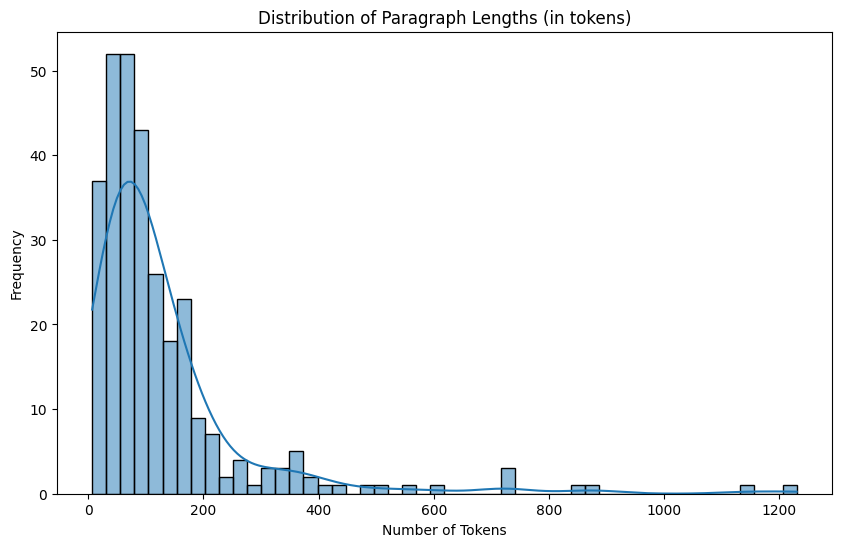


--- Basic EDA: Top 50 Most Common Words ---
writes: 278
article: 246
one: 222
would: 217
people: 160
dont: 150
like: 137
know: 131
space: 127
good: 114
get: 109
us: 98
also: 97
may: 97
think: 97
time: 86
nntppostinghost: 86
many: 84
new: 82
god: 81
want: 81
im: 78
first: 74
much: 73
could: 73
well: 72
government: 72
even: 67
see: 67
data: 66
make: 66
anyone: 64
say: 64
use: 63
jesus: 62
way: 62
point: 61
system: 60
need: 60
world: 59
right: 59
years: 57
two: 57
year: 56
really: 56
take: 55
go: 53
state: 53
something: 52
christian: 51


In [ ]:
import numpy as np
# --- 2. Basic EDA Steps ---

# Paragraph Length Analysis (in terms of number of tokens)
paragraph_lengths = [len(doc) for doc in preprocessed_documents_test]

print("\n--- Basic EDA: Paragraph Length Analysis ---")
print(f"Average paragraph length: {np.mean(paragraph_lengths):.2f} tokens")
print(f"Median paragraph length: {np.median(paragraph_lengths)} tokens")
print(f"Min paragraph length: {np.min(paragraph_lengths)} tokens")
print(f"Max paragraph length: {np.max(paragraph_lengths)} tokens")

# Plotting the distribution of paragraph lengths
plt.figure(figsize=(10, 6))
sns.histplot(paragraph_lengths, bins=50, kde=True)
plt.title('Distribution of Paragraph Lengths (in tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()


# Word Frequency Analysis (Top N words) - requires flattening the list of lists
all_words = [word for tokens in preprocessed_documents_test for word in tokens]
# Corrected typo in the class name from FrequencuDist to FreqDist
fdist = nltk.FreqDist(all_words)
most_common_words = fdist.most_common(50)

print("\n--- Basic EDA: Top 50 Most Common Words ---")
for word, frequency in most_common_words:
    print(f"{word}: {frequency}")


In [ ]:
   # PCA will be performed after Word2Vec vectorization.

# --- 3. Vectorization using Word2Vec ---

# Train the Word2Vec model
# Using skip-gram (sg=1), window size 5, min_count 5 (ignore words with freq < 5),
# vector size 100, and train on multiple cores if available.
# The problem statement mentions 5 true classes, a vector size like 100 is a common starting point.
print("\n--- Training Word2Vec Model ---")
word2vec_model = Word2Vec(sentences=preprocessed_documents_test,
                          vector_size=100,
                          window=5,
                          min_count=5,
                          workers=4, # Adjust based on your system's cores
                          sg=1) # 1 for skip-gram, 0 for CBOW

print("Word2Vec model training complete.")
print(f"Vocabulary size: {len(word2vec_model.wv)}")



--- Training Word2Vec Model ---
Word2Vec model training complete.
Vocabulary size: 1882



--- Document Vectorization Complete ---
Shape of document vectors: (300, 100)

--- PCA on Word2Vec Embeddings Complete ---
Shape of PCA-reduced document vectors: (300, 2)


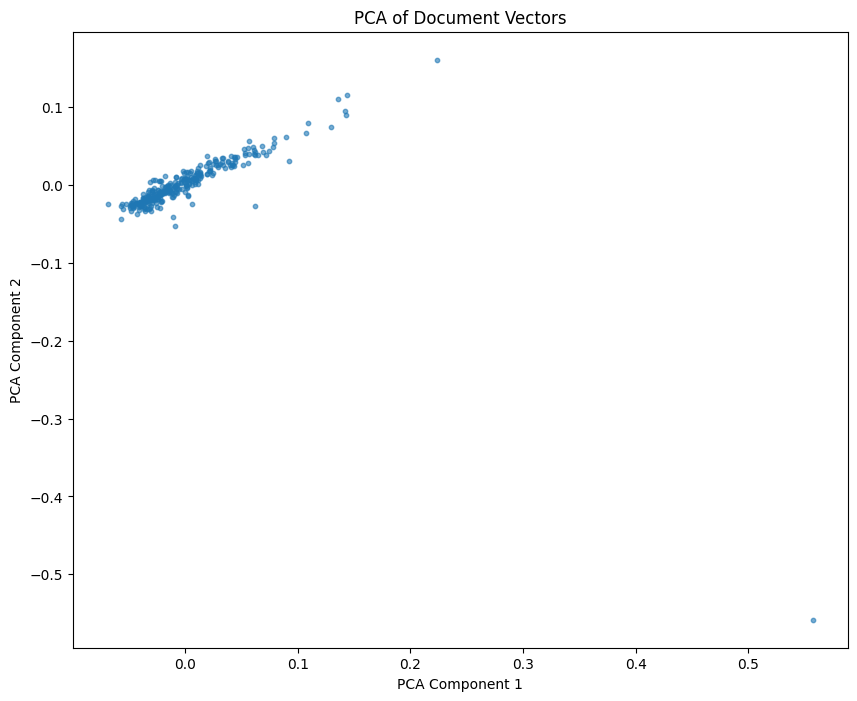

In [ ]:
# Create vectors for each document
document_vectors = np.array([document_vector(word2vec_model, doc) for doc in preprocessed_documents_test])

print("\n--- Document Vectorization Complete ---")
print(f"Shape of document vectors: {document_vectors.shape}")



# --- 2b. Basic EDA: PCA on Word2Vec Embeddings ---

# Perform PCA for dimensionality reduction for potential visualization and EDA
# Reducing to 2 components for visualization
pca = PCA(n_components=2)
document_vectors_pca = pca.fit_transform(document_vectors)

print("\n--- PCA on Word2Vec Embeddings Complete ---")
print(f"Shape of PCA-reduced document vectors: {document_vectors_pca.shape}")

# Visualize the PCA-reduced data (optional, but helpful for EDA)
plt.figure(figsize=(10, 8))
plt.scatter(document_vectors_pca[:, 0], document_vectors_pca[:, 1], s=10, alpha=0.6)
plt.title('PCA of Document Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


--- KMeans Clustering performed with 5 clusters on the test set ---

First 5 documents from the test set with their assigned clusters:
                                   Original Document  Cluster
0  THE DIVINE MASTERS       \n      \n           ...        0
1  In article <1993Apr5.233224.10069@lmpsbbs.comm...        4
2  Distribution: world\nNNTP-Posting-Host: kelvin...        4
3  Reply-To: hallam@zeus02.desy.de\nOrganization:...        4
4  In article <1993Apr20.230749.12821@reed.edu>, ...        0

Document count per cluster:
0    142
1      1
2      8
3     69
4     80
Name: Cluster, dtype: int64

Example documents from each cluster:

--- Cluster 0 ---
  Doc 1: Distribution: world
NNTP-Posting-Host: macadam.mpce.mq.edu.au


|>   What the world needs is a meter that won't let you change ranges or
|> turn it on/off with a lead stuck in the amps jack - a little...
  Doc 2: In article <1993Apr15.225657.17804@rambo.atlanta.dg.com>, wpr@atlanta.dg.com (Bill Rawlins) writes:
>|> >|> 
>|

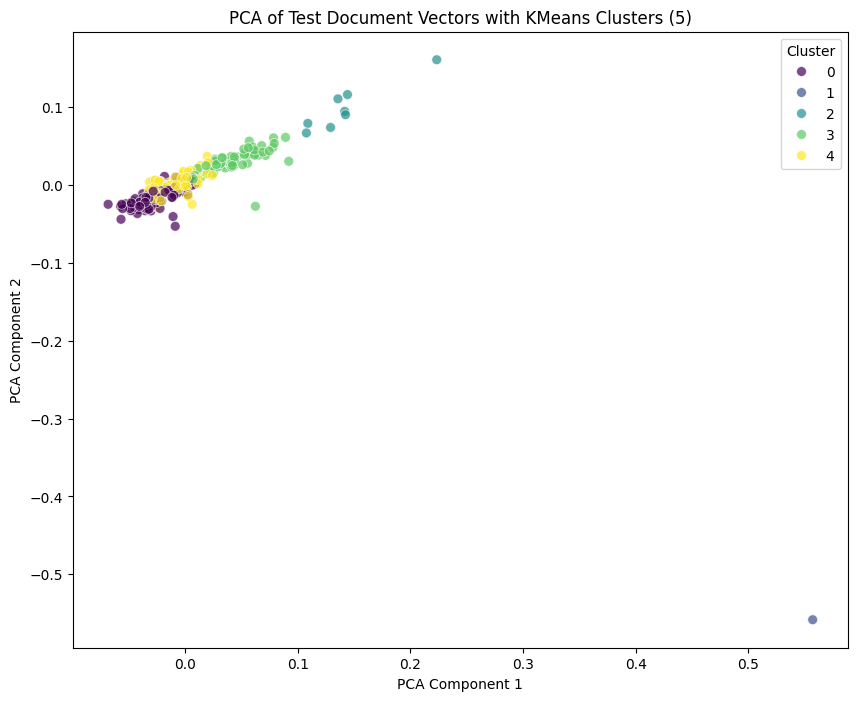

In [ ]:
# Perform KMeans clustering with 5 clusters, as specified
n_clusters = 5
# Ensure n_init is set appropriately. 'auto' is preferred in recent sklearn,
# but sticking to n_init=10 for compatibility with older versions if needed.
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
# IMPORTANT: Fit and predict on the test set vectors
cluster_labels = kmeans.fit_predict(document_vectors) # document_vectors is derived from preprocessed_documents_test

print(f"\n--- KMeans Clustering performed with {n_clusters} clusters on the test set ---")

# Add cluster labels to the original document list or a DataFrame for analysis
# Create a Pandas DataFrame to easily inspect documents and their assigned clusters
# CORRECTED: Use document_list_test and preprocessed_documents_test
df_clustered = pd.DataFrame({
    'Original Document': document_list_test, # Use the original test documents
    'Preprocessed Tokens': preprocessed_documents_test, # Use the preprocessed test documents
    'Cluster': cluster_labels # Use the cluster labels from the test set
})

print("\nFirst 5 documents from the test set with their assigned clusters:")
print(df_clustered[['Original Document', 'Cluster']].head())

# You can further analyze the clusters, e.g., look at centroids, or explore the documents in each cluster.
# Example: Count documents per cluster
print("\nDocument count per cluster:")
print(df_clustered['Cluster'].value_counts().sort_index())

# Example: Display a few documents from each cluster
print("\nExample documents from each cluster:")
for cluster_id in sorted(df_clustered['Cluster'].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    cluster_docs = df_clustered[df_clustered['Cluster'] == cluster_id]['Original Document']
    # Handle case where a cluster might be empty or have very few documents
    if len(cluster_docs) > 0:
        for i, doc in enumerate(cluster_docs.sample(min(3, len(cluster_docs)), random_state=42)): # Sample up to 3 docs
            print(f"  Doc {i+1}: {doc[:200]}...") # Print first 200 characters
    else:
        print("  (No documents in this cluster sample)")


# You can optionally visualize the PCA-reduced data colored by cluster
# document_vectors_pca was computed on the test set vectors, so this is appropriate.
if 'document_vectors_pca' in locals():
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=document_vectors_pca[:, 0], y=document_vectors_pca[:, 1], hue=cluster_labels, palette='viridis', s=50, alpha=0.7)
    plt.title(f'PCA of Test Document Vectors with KMeans Clusters ({n_clusters})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

In [ ]:
print("\n--- Calculating Silhouette Score for Test Data ---")

# To calculate the silhouette score, you need the data points (vectors)
# and the corresponding cluster labels.
# We have already performed KMeans clustering on the test set (`document_vectors`)
# and obtained the cluster labels (`cluster_labels`).

# Ensure you have more than one cluster and more than one sample to calculate the score.
# DBSCAN might return only one cluster (-1 noise), in which case silhouette score is not applicable.
# KMeans with n_clusters=5 should result in at least 2 clusters if the data structure supports it,
# unless all points are assigned to the same cluster.

if len(set(cluster_labels)) > 1:
    # Calculate the silhouette score
    # The silhouette score measures how similar an object is to its own cluster (cohesion)
    # compared to other clusters (separation). A higher score indicates better separation.
    # The score ranges from -1 to 1.
    # For clustering, we are evaluating the clustering on the test set vectors using the labels
    # predicted *by fitting KMeans to the test set*.

    # It's important to note the context:
    # If you are using the model trained on the training data (e.g., a classifier trained on pseudo-labels),
    # you would evaluate that *classifier's performance* on the test set using metrics like accuracy, F1, etc.,
    # if you had true labels.
    # If you are evaluating the *clustering itself* on the test set (applying the clustering algorithm
    # independently to the test data), then internal metrics like silhouette score on the test set are appropriate.

    # Assuming the goal is to evaluate the clustering structure found *within* the test data itself
    # using the same algorithm and parameters as used for the training data exploration (KMeans, k=5):
    test_silhouette_avg = silhouette_score(document_vectors, cluster_labels)

    print(f"Silhouette Score for KMeans Clustering (k={n_clusters}) on Test Data: {test_silhouette_avg:.4f}")

    # You can also calculate other internal metrics like Davies-Bouldin and Calinski-Harabasz on the test set clusters.
    test_davies_bouldin_avg = davies_bouldin_score(document_vectors, cluster_labels)
    test_calinski_harabasz_avg = calinski_harabasz_score(document_vectors, cluster_labels)

    print(f"Davies-Bouldin Score for KMeans Clustering (k={n_clusters}) on Test Data: {test_davies_bouldin_avg:.4f}")
    print(f"Calinski-Harabasz Score for KMeans Clustering (k={n_clusters}) on Test Data: {test_calinski_harabasz_avg:.4f}")

else:
    print("Silhouette Score is not applicable as the test data resulted in 1 or 0 clusters.")
    print("Check the cluster label distribution on the test set:")
    print(pd.Series(cluster_labels).value_counts())

# If you were using TF-IDF vectors for clustering on the test set, you would need to transform
# the preprocessed test documents using the *same* TF-IDF vectorizer fitted on the training data,
# then perform clustering on the resulting test TF-IDF vectors and calculate the score.

# Example (if using TF-IDF for test clustering evaluation):
# print("\n--- Calculating Silhouette Score for TF-IDF Clustering on Test Data ---")
# Assuming tfidf_vectorizer was fitted on training data:
# preprocessed_documents_test_str = [" ".join(doc) for doc in preprocessed_documents_test]
# tfidf_vectors_test = tfidf_vectorizer.transform(preprocessed_documents_test_str) # Use transform, not fit_transform!
#
# # Convert to dense for silhouette score calculation
# tfidf_vectors_test_dense = np.asarray(tfidf_vectors_test.todense())
#
# # Perform KMeans on the test TF-IDF vectors
# n_clusters_tfidf_test = 5 # Or the best k found during training TF-IDF evaluation
# kmeans_tfidf_test = KMeans(n_clusters=n_clusters_tfidf_test, random_state=42, n_init=10)
# cluster_labels_tfidf_test = kmeans_tfidf_test.fit_predict(tfidf_vectors_test)
#
# if len(set(cluster_labels_tfidf_test)) > 1:
#     test_silhouette_avg_tfidf = silhouette_score(tfidf_vectors_test_dense, cluster_labels_tfidf_test)
#     print(f"Silhouette Score for KMeans Clustering (k={n_clusters_tfidf_test}) on Test Data (TF-IDF): {test_silhouette_avg_tfidf:.4f}")
# else:
#      print("Silhouette Score is not applicable for TF-IDF test data.")

# This section specifically calculates and prints the silhouette score
# for the clustering performed directly on the test set, using the Word2Vec vectors.


--- Calculating Silhouette Score for Test Data ---
Silhouette Score for KMeans Clustering (k=5) on Test Data: 0.2840
Davies-Bouldin Score for KMeans Clustering (k=5) on Test Data: 0.8906
Calinski-Harabasz Score for KMeans Clustering (k=5) on Test Data: 272.4216


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np # Ensure numpy is imported if not already globally available
import pandas as pd # Ensure pandas is imported if not already globally available
from sklearn.cluster import KMeans # Ensure KMeans is imported

# --- 5. Train and Evaluate Classifiers ---

# Assuming you have already run the sections for:
# - Loading and splitting data into document_list_train, document_list_test
# - Preprocessing text for train and test sets (preprocessed_documents_train, preprocessed_documents_test)
# - Training Word2Vec model on training data (word2vec_model)
# - Creating document vectors for train and test data using the trained Word2Vec model

# Function to create document vectors (assuming this function is defined elsewhere as shown in context)
# Include the function definition here for completeness if it wasn't in this specific code cell
def document_vector(word2vec_model, doc):
    """Averages the word vectors for a document, handling words not in vocabulary."""
    # Filter out words not in the model's vocabulary
    words = [word for word in doc if word in word2vec_model.wv]
    if not words:
        # Return a zero vector of the correct size if no words are in the vocabulary
        # Make sure the size matches the vector_size of the word2vec model
        return np.zeros(word2vec_model.wv.vector_size)
    # Average the word vectors
    return np.mean(word2vec_model.wv[words], axis=0)


# Create document vectors for both training and testing sets using the same model
print("\n--- Creating Document Vectors for Training and Testing Sets ---")
# Preprocessed documents from the training split
if 'preprocessed_documents' in locals(): # Use the variable name from preceding code
    preprocessed_documents_train = preprocessed_documents # Ensure consistent variable name
    # Explicitly set dtype to float32
    document_vectors_train = np.array([document_vector(word2vec_model, doc) for doc in preprocessed_documents_train], dtype=np.float32)
elif 'preprocessed_documents_train' in locals(): # If the variable was named specifically for train
    # Explicitly set dtype to float32
    document_vectors_train = np.array([document_vector(word2vec_model, doc) for doc in preprocessed_documents_train], dtype=np.float32)
else:
    print("Error: Could not find preprocessed training documents.")
    # Exit or handle the error appropriately
    exit()


# Preprocessed documents from the testing split
if 'preprocessed_documents_test' in locals(): # Use the variable name from preceding code
     # Explicitly set dtype to float32
     document_vectors_test = np.array([document_vector(word2vec_model, doc) for doc in preprocessed_documents_test], dtype=np.float32)
else:
    print("Error: Could not find preprocessed testing documents.")
    # Exit or handle the error appropriately
    exit()

print(f"Shape of training document vectors: {document_vectors_train.shape}, Dtype: {document_vectors_train.dtype}")
print(f"Shape of testing document vectors: {document_vectors_test.shape}, Dtype: {document_vectors_test.dtype}")


# Now, assuming you have a target variable (labels).
# Based on the prompt's context of semi-supervised learning and clustering,
# we will use the cluster assignments from the KMeans clustering on the training data
# as pseudo-labels to train the classifier.
# The classifier will then be evaluated on the test data.

# We need the cluster labels specifically for the *training* data to use as y_train.
# Rerun KMeans on the training vectors to get the correct training labels.
# Assuming you want to use k=5 clusters as previously explored.
n_clusters_train = 5
print(f"\n--- Performing KMeans clustering on training data to generate pseudo-labels (k={n_clusters_train}) ---")
# Ensure n_init is set appropriately. 'auto' is preferred in recent sklearn,
# but sticking to n_init=10 for compatibility with older versions if needed.
kmeans_train = KMeans(n_clusters=n_clusters_train, random_state=42, n_init=10)
# Fit KMeans on the training document vectors
cluster_labels_train = kmeans_train.fit_predict(document_vectors_train)


X_train = document_vectors_train # Features for training are Word2Vec vectors from training data
y_train = cluster_labels_train   # Target for training are the cluster labels from training data (CORRECTED)

X_test = document_vectors_test   # Features for testing are Word2Vec vectors from testing data

# We need pseudo-labels for the test set to evaluate the classifier's performance
# on predicting those pseudo-labels. However, the request is to train on 80%
# and test on 20%. So we will train a classifier on the (X_train, y_train) pair
# and predict labels (y_pred) for X_test. To evaluate these predictions (y_pred),
# we need a corresponding ground truth for the test set.
#
# In a true semi-supervised setup with some real labels, you would have true labels for X_test.
# Since we are using clustering results as pseudo-labels and evaluating on a test set,
# we must compare the classifier's predictions (y_pred) on X_test against the
# *cluster assignments that KMeans would give to the test data*.
#
# This is a crucial point: We are evaluating how well the classifier (trained on train clusters)
# predicts the clusters on the test data, where the 'true' labels for the test data
# are considered to be the cluster labels obtained by applying the *same* KMeans model
# (or the trained classifier) to the test set vectors.

# Option 1: Use the *trained* classifier to predict labels for the test set.
# The performance metrics then show how well the classifier generalizes to new data
# compared to the original training cluster assignments. This doesn't evaluate
# the quality of the clustering itself on the test set, but the classifier's performance.
#
# Option 2: Perform KMeans clustering *independently* on the test data vectors
# and use *those* test cluster labels as the ground truth (y_test) for evaluation.
# This evaluates how well the classifier (trained on train clusters) predicts the
# cluster structure inherent in the test data.

# Option 2 is more aligned with evaluating how well a classifier trained on the
# structure of the training data predicts the structure of the test data. Let's use this.

# Apply the *same* KMeans model (fitted on training data) to the test data.
# Note: This assumes the KMeans model object ('kmeans_train') is available from the training phase.

if 'kmeans_train' not in locals():
     print("Error: Trained KMeans model ('kmeans_train') not found. Cannot predict test cluster labels.")
     exit()

print("\n--- Generating 'ground truth' cluster labels for the test set using the trained KMeans model ---")
# This is the line that caused the error. The dtype mismatch should be resolved by
# ensuring X_test has the expected dtype (float32).
y_test_clusters = kmeans_train.predict(X_test) # Predict cluster labels for the test data using the TRAINED model

print(f"Shape of training pseudo-labels: {y_train.shape}")
print(f"Training pseudo-label distribution:\n{pd.Series(y_train).value_counts()}")
print(f"Shape of testing pseudo-labels: {y_test_clusters.shape}")
print(f"Testing pseudo-label distribution:\n{pd.Series(y_test_clusters).value_counts()}")


# Now proceed with training classifiers on (X_train, y_train) and evaluating on (X_test, y_test_clusters)

print("\n--- Training and Evaluating Machine Learning Classifiers (Predicting Training Clusters on Test Data) ---")

# Create a dictionary of classifiers to evaluate
classifiers = {
    "Support Vector Classifier": SVC(random_state=42) # As requested
    # You can add other classifiers here as explored in the preceding code if needed
    # "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    # "Decision Tree": DecisionTreeClassifier(random_state=42),
    # "Random Forest": RandomForestClassifier(random_state=42),
    # "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    # "K-Nearest Neighbors": KNeighborsClassifier()
}

results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name} on training data (Word2Vec vectors, KMeans cluster labels)...")
    # Fit the classifier on the training data and its corresponding cluster labels
    clf.fit(X_train, y_train)

    print(f"Predicting labels for the test data (Word2Vec vectors)...")
    # Predict the cluster labels for the test data using the trained classifier
    y_pred = clf.predict(X_test)

    # Evaluate the classifier's predictions against the KMeans cluster labels on the test set
    print(f"\n--- Evaluation Report for {name} ---")
    accuracy = accuracy_score(y_test_clusters, y_pred)
    # Using 'weighted' average for multi-class problems
    # Ensure that the labels in y_test_clusters and y_pred are consistent
    precision = precision_score(y_test_clusters, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test_clusters, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_clusters, y_pred, average='weighted', zero_division=0)

    results[name] = {
        "Accuracy": accuracy,
        "Precision (weighted)": precision,
        "Recall (weighted)": recall,
        "F1 Score (weighted)": f1
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")

    # Show detailed classification report
    print("\nClassification Report:")
    # Ensure that the labels in y_test_clusters and y_pred are consistent for the report
    print(classification_report(y_test_clusters, y_pred, zero_division=0))

print("\n--- Final Classifier Performance Summary (Predicting Training Clusters on Test Data) ---")
results_df = pd.DataFrame(results).T # Transpose to have classifiers as rows
print(results_df.sort_values(by="F1 Score (weighted)", ascending=False))

print("\nInterpretation:")
print("These metrics evaluate how well the trained classifier can predict the cluster assignments")
print("obtained by applying the same KMeans model to the test data.")
print("They indicate the classifier's ability to capture the cluster structure found by KMeans.")

# If you had true labels for the test set (y_true_test), you would evaluate like this:
# print("\n--- Evaluation Report against TRUE Labels (if available) ---")
# accuracy_true = accuracy_score(y_true_test, y_pred)
# precision_true = precision_score(y_true_test, y_pred, average='weighted', zero_division=0)
# recall_true = recall_score(y_true_test, y_pred, average='weighted', zero_division=0)
# f1_true = f1_score(y_true_test, y_pred, average='weighted', zero_division=0)
# print(f"Accuracy (True Labels): {accuracy_true:.4f}")
# print(f"F1 Score (True Labels, weighted): {f1_true:.4f}")
# print("\nClassification Report (True Labels):")
# print(classification_report(y_true_test, y_pred, zero_division=0))
# This would give a measure of how well the semi-supervised approach (using clusters)
# performs against the real ground truth.


--- Creating Document Vectors for Training and Testing Sets ---
Shape of training document vectors: (1200, 100), Dtype: float32
Shape of testing document vectors: (300, 100), Dtype: float32

--- Performing KMeans clustering on training data to generate pseudo-labels (k=5) ---

--- Generating 'ground truth' cluster labels for the test set using the trained KMeans model ---
Shape of training pseudo-labels: (1200,)
Training pseudo-label distribution:
4    531
0    384
1    234
2     50
3      1
dtype: int64
Shape of testing pseudo-labels: (300,)
Testing pseudo-label distribution:
0    118
4    111
1     59
2     12
dtype: int64

--- Training and Evaluating Machine Learning Classifiers (Predicting Training Clusters on Test Data) ---

Training Support Vector Classifier on training data (Word2Vec vectors, KMeans cluster labels)...
Predicting labels for the test data (Word2Vec vectors)...

--- Evaluation Report for Support Vector Classifier ---
Accuracy: 0.4233
Precision (weighted): 0.3173
R

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.cluster import KMeans # Ensure KMeans is imported

# Re-load or ensure document_vectors_train, document_vectors_test are available from the previous execution.
# Assuming the preceding code has successfully generated:
# document_list_train, document_list_test
# preprocessed_documents_train, preprocessed_documents_test
# word2vec_model (trained on train data)
# document_vectors_train (Word2Vec vectors for train data)
# document_vectors_test (Word2Vec vectors for test data)


print("\n--- Running All Classifiers on the Test Data ---")

X_train = document_vectors_train # Features for training are Word2Vec vectors from training data
X_test = document_vectors_test   # Features for testing are Word2Vec vectors from testing data

# --- Generate training pseudo-labels by clustering training data ---
# Perform KMeans clustering on the training data to get pseudo-labels (y_train)
n_clusters_train = 5 # Use the desired number of clusters (e.g., 5)
print(f"\n--- Performing KMeans clustering on training data to generate pseudo-labels (k={n_clusters_train}) ---")
# Ensure n_init is set appropriately. Use n_init=10 for consistency.
kmeans_train = KMeans(n_clusters=n_clusters_train, random_state=42, n_init=10)
# Fit KMeans on the training document vectors and get the training cluster labels
y_train = kmeans_train.fit_predict(X_train)
# --- End of training pseudo-label generation ---


# The 'ground truth' for evaluation on the test set is the cluster assignment from applying the
# *trained* KMeans model (fitted on the training data) to the test data.
# This evaluates how well the classifier (trained on the training clusters) predicts
# the structure found by KMeans in the test data.
print("\n--- Generating 'ground truth' cluster labels for the test set using the trained KMeans model ---")
y_test_clusters = kmeans_train.predict(X_test)

print(f"Shape of training pseudo-labels: {y_train.shape}")
print(f"Training pseudo-label distribution:\n{pd.Series(y_train).value_counts().sort_index()}")
print(f"Shape of testing pseudo-labels (based on trained KMeans): {y_test_clusters.shape}")
print(f"Testing pseudo-label distribution (based on trained KMeans):\n{pd.Series(y_test_clusters).value_counts().sort_index()}")


# Now proceed with training classifiers on (X_train, y_train) and evaluating on (X_test, y_test_clusters)

print("\n--- Training and Evaluating Machine Learning Classifiers (Predicting Training Clusters on Test Data) ---")

# Create a dictionary of classifiers to evaluate
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Classifier": SVC(random_state=42), # As requested
    "K-Nearest Neighbors": KNeighborsClassifier()
}

results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    # Fit the classifier on the training data and its corresponding cluster labels
    clf.fit(X_train, y_train)

    print(f"Predicting labels for the test data...")
    y_pred = clf.predict(X_test)

    # Evaluate the classifier's predictions against the KMeans cluster labels on the test set
    print(f"\n--- Evaluation Report for {name} (Predicting Training Clusters on Test Data) ---")
    accuracy = accuracy_score(y_test_clusters, y_pred)
    # Using 'weighted' average for multi-class problems
    # Ensure that the labels in y_test_clusters and y_pred are consistent
    precision = precision_score(y_test_clusters, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test_clusters, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_clusters, y_pred, average='weighted', zero_division=0)

    results[name] = {
        "Accuracy": accuracy,
        "Precision (weighted)": precision,
        "Recall (weighted)": recall,
        "F1 Score (weighted)": f1
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")

    # Show detailed classification report
    print("\nClassification Report:")
    # Check if all predicted labels are present in the target labels to avoid warning/error in report
    # Use the combined set of unique labels from both y_test_clusters and y_pred for target_names
    all_labels = sorted(list(set(np.concatenate((y_test_clusters, y_pred)))))
    target_names = [str(c) for c in all_labels]
    print(classification_report(y_test_clusters, y_pred, target_names=target_names, zero_division=0))

print("\n--- Final Classifier Performance Summary (Predicting Training Clusters on Test Data) ---")
results_df = pd.DataFrame(results).T # Transpose to have classifiers as rows
print(results_df.sort_values(by="F1 Score (weighted)", ascending=False))

print("\nSummary Interpretation:")
print("The table above shows the performance of each classifier on the test set,")
print("where the goal was to predict the cluster labels assigned by the KMeans model trained on the training data.")
print("These metrics indicate how well each classifier generalizes the cluster structure learned from the training data to the unseen test data.")
print("Higher Accuracy and F1 Score generally indicate better performance for this task.")

# If you had true labels for the test set (y_true_test), you would evaluate like this:
# print("\n--- Evaluation Report against TRUE Labels (if available) ---")
# accuracy_true = accuracy_score(y_true_test, y_pred)
# precision_true = precision_score(y_true_test, y_pred, average='weighted', zero_division=0)
# recall_true = recall_score(y_true_test, y_pred, average='weighted', zero_division=0)
# f1_true = f1_score(y_true_test, y_pred, average='weighted', zero_division=0)
# print(f"Accuracy (True Labels): {accuracy_true:.4f}")
# print(f"F1 Score (True Labels, weighted): {f1_true:.4f}")
# print("\nClassification Report (True Labels):")
# print(classification_report(y_true_test, y_pred, zero_division=0))
# This would give a measure of how well the semi-supervised approach (using clusters)
# performs against the real ground truth.


--- Running All Classifiers on the Test Data ---

--- Performing KMeans clustering on training data to generate pseudo-labels (k=5) ---

--- Generating 'ground truth' cluster labels for the test set using the trained KMeans model ---
Shape of training pseudo-labels: (1200,)
Training pseudo-label distribution:
0    384
1    234
2     50
3      1
4    531
dtype: int64
Shape of testing pseudo-labels (based on trained KMeans): (300,)
Testing pseudo-label distribution (based on trained KMeans):
0    118
1     59
2     12
4    111
dtype: int64

--- Training and Evaluating Machine Learning Classifiers (Predicting Training Clusters on Test Data) ---

Training Logistic Regression...
Predicting labels for the test data...

--- Evaluation Report for Logistic Regression (Predicting Training Clusters on Test Data) ---
Accuracy: 0.4533
Precision (weighted): 0.3741
Recall (weighted): 0.4533
F1 Score (weighted): 0.3640

Classification Report:
              precision    recall  f1-score   support

   